In [1]:
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import root_mean_squared_error, mean_squared_error, mean_absolute_percentage_error, r2_score, mean_absolute_error
import pandas as pd
import torch.optim as optim
import torch.nn as nn
from torch import nn
import gc
import os
import numpy as np
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
data_dir = os.path.join(parent_dir, "TestSet")
print(f"Data directory: {data_dir}")

scaler_dir = os.path.join(current_dir, "Scaler")
X_seq_scaler_path    = os.path.join(scaler_dir, "X_seq_minmax_scaler.npz")
X_static_scaler_path = os.path.join(scaler_dir, "X_static_minmax_scaler.npz")
Y_scaler_path        = os.path.join(scaler_dir, "Y_static_minmax_scaler.npz")

seq_len = 100

X_seq_test = np.load(os.path.join(data_dir, "X_seq_test.npy"))
X_static_test = np.load(os.path.join(data_dir, "X_static_test.npy"))
Y_test = np.load(os.path.join(data_dir, "Y_test.npy"))
print("Test set:", X_seq_test.shape, X_static_test.shape, Y_test.shape)

case_dir = os.path.join(data_dir, "test_cases")
test_data_per_case = {}

if not os.path.isdir(case_dir):
    raise FileNotFoundError(f"Test condition catalog not found: {case_dir}")

case_ids = []
for fn in os.listdir(case_dir):
    if fn.startswith("X_seq_case") and fn.endswith(".npy"):
        cid = int(fn.replace("X_seq_case", "").replace(".npy", ""))
        case_ids.append(cid)
case_ids = sorted(case_ids)

for cid in case_ids:
    X_seq_case = np.load(os.path.join(case_dir, f"X_seq_case{cid}.npy"))
    X_static_case = np.load(os.path.join(case_dir, f"X_static_case{cid}.npy"))
    Y_case = np.load(os.path.join(case_dir, f"Y_case{cid}.npy"))
    test_data_per_case[cid] = (X_seq_case, X_static_case, Y_case)

print(f"✅ test_data_per_case : {len(test_data_per_case)} test case -> {list(test_data_per_case.keys())}")

def load_minmax_scaler(path):
    data = np.load(path)
    return data["min_val"], data["max_val"]

X_seq_min, X_seq_max       = load_minmax_scaler(X_seq_scaler_path)
X_static_min, X_static_max = load_minmax_scaler(X_static_scaler_path)
Y_min, Y_max               = load_minmax_scaler(Y_scaler_path)


def apply_minmax(x, min_val, max_val):
    return (x - min_val) / (max_val - min_val + 1e-8)

test_data_per_case_norm = {}
for cid, (X_seq_case, X_static_case, Y_case) in test_data_per_case.items():
    X_seq_flat = X_seq_case.reshape(-1, X_seq_case.shape[-1])
    X_seq_case_norm = apply_minmax(X_seq_flat, X_seq_min, X_seq_max).reshape(X_seq_case.shape)
    X_static_case_norm = apply_minmax(X_static_case, X_static_min, X_static_max)
    Y_case_norm = apply_minmax(Y_case, Y_min, Y_max)

    X_seq_case_norm = X_seq_case_norm.reshape(-1, 100, 2)
    X_static_case_norm = X_static_case_norm.reshape(-1, 1)
    
    X_case_norm = torch.cat([torch.tensor(X_seq_case_norm, dtype=torch.float32), 
                             torch.tensor(X_static_case_norm, dtype=torch.float32).unsqueeze(1).expand(-1, 100, -1)], dim=-1)

    test_data_per_case_norm[cid] = (X_case_norm, Y_case_norm)

print("✅ test_data_per_case_norm established")

X_seq_test_t = torch.tensor(X_seq_test, dtype=torch.float32)
X_static_test_t = torch.tensor(X_static_test, dtype=torch.float32)
Y_test_t = torch.tensor(Y_test, dtype=torch.float32)

test_X = torch.cat([X_seq_test_t, X_static_test_t.unsqueeze(1).expand(-1, seq_len, -1)], dim=-1)
test_dataset  = TensorDataset(test_X, Y_test_t)
batch_size = 256
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True)

Data directory: d:\0DATA\NHRI\Python Code\4、代理模型_水深预测\GitHub\上传 - 1.5\TestSet
Test set: (13006, 100, 2) (13006, 1) (13006, 6)
✅ test_data_per_case : 9 test case -> [3, 6, 13, 15, 22, 24, 34, 38, 42]
✅ test_data_per_case_norm established


In [3]:
if isinstance(test_X, torch.Tensor):
    test_X_flat = test_X.cpu().numpy().reshape(test_X.shape[0], -1)
else:
    test_X_flat = test_X.reshape(test_X.shape[0], -1)

if isinstance(Y_test_t, torch.Tensor):
    Y_test_np = Y_test_t.cpu().numpy()
else:
    Y_test_np = Y_test_t

print("test_X_flat.shape:", test_X_flat.shape)
print("Y_test_np.shape:", Y_test_np.shape)

# ====== 构造 test Pool（仅用于预测 / 评估） ======
from catboost import Pool

test_pool = Pool(data=test_X_flat, label=Y_test_np)

test_X_flat.shape: (13006, 300)
Y_test_np.shape: (13006, 6)


In [4]:
import numpy as np
import torch
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from catboost import CatBoostRegressor

current_dir = os.getcwd()
data_dir = os.path.join(current_dir, "Best_Catboost.cbm")  # 连接到 TestSet 文件夹
print(f"Data directory: {data_dir}")

cat_model = CatBoostRegressor()
cat_model.load_model(data_dir)

Data directory: d:\0DATA\NHRI\Python Code\4、代理模型_水深预测\GitHub\上传 - 1.5\5_Catboost\Best_Catboost.cbm


In [5]:
Y_min_t = torch.tensor(Y_min, dtype=torch.float32, device=device)  
Y_max_t = torch.tensor(Y_max, dtype=torch.float32, device=device) 
Y_range_t = (Y_max_t - Y_min_t).clamp_min(1e-8)                   

In [6]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

def median_absolute_error(y_true, y_pred):
    """Median Absolute Error (MdAE)"""
    errors = np.abs(y_true - y_pred)
    return np.median(errors)

def iqr_based_mae(y_true, y_pred):
    """IQR-based MAE"""
    errors = np.abs(y_true - y_pred).flatten()
    q1 = np.percentile(errors, 25)
    q3 = np.percentile(errors, 75)
    mask = (errors >= q1) & (errors <= q3)
    filtered_errors = errors[mask]
    if len(filtered_errors) == 0:
        return np.nan
    return np.mean(filtered_errors)


def NSE(y_true, y_pred, eps=1e-8):
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    return 1.0 - np.sum((y_true - y_pred)**2) / (np.sum((y_true - np.mean(y_true))**2) + eps)


def hit_rate(y_true, y_pred, delta, eps=1e-8):
    """Hit Rate (%)"""
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    relative_errors = np.abs((y_pred - y_true) / (y_true + eps)) * 100
    hits = relative_errors <= delta
    return np.mean(hits) * 100


def KGE(y_true, y_pred, eps=1e-8):
    """Kling–Gupta Efficiency"""
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    r = np.corrcoef(y_true, y_pred)[0, 1]
    beta = np.mean(y_pred) / (np.mean(y_true) + eps)
    gamma = (np.std(y_pred) / (np.mean(y_pred) + eps)) / (np.std(y_true) / (np.mean(y_true) + eps))
    return 1 - np.sqrt((r - 1)**2 + (beta - 1)**2 + (gamma - 1)**2)


def willmott_index_modified(observed, predicted, eps=1e-8):
    """Willmott's Modified Index of Agreement (Willmott et al., 2012)"""
    observed = np.asarray(observed).flatten()
    predicted = np.asarray(predicted).flatten()

    numerator = np.sum(np.abs(predicted - observed))
    denominator = 2 * np.sum(np.abs(observed - np.mean(observed))) + eps

    d = 1 - numerator / denominator
    return np.clip(d, 0, 1)

In [7]:
max_delta=5
deltas = np.arange(0.25, max_delta+0.25, 0.25)  # δ = 1% ~ max_delta%
print(deltas)

def evaluate_metrics(y_true, y_pred, eps=1e-8):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)

    diff = y_pred - y_true

    mse = np.mean(diff**2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(diff))
    mape = np.mean(np.abs(diff / (y_true + eps)))
    sse = np.sum(diff**2)
    sst = np.sum((y_true - np.mean(y_true))**2) + eps
    r2 = 1.0 - sse / sst
    nse = r2

    kge = KGE(y_true, y_pred)
    d_index = willmott_index_modified(y_true, y_pred)
    hr = [hit_rate(y_true, y_pred, d) for d in deltas]
    mdae = median_absolute_error(y_true, y_pred)
    iqr_mae = iqr_based_mae(y_true, y_pred)
    max_err = np.max(np.abs(diff))

    return {
        "MSE": mse,
        "RMSE": rmse,
        "MAE": mae,
        "MAPE": mape,
        "R2": r2,          
        "NSE": nse,
        "KGE": kge,
        "d": d_index,
        "HitRate": hr,
        "MdAE": mdae,
        "IQR-based MAE": iqr_mae,
        "MaxError": max_err,
    }

[0.25 0.5  0.75 1.   1.25 1.5  1.75 2.   2.25 2.5  2.75 3.   3.25 3.5
 3.75 4.   4.25 4.5  4.75 5.  ]


In [8]:
def predict_cat(model, X):
    return model.predict(X)

In [9]:
X_seq_test_norm = apply_minmax(X_seq_test, X_seq_min, X_seq_max)
X_static_test_norm = apply_minmax(X_static_test, X_static_min, X_static_max)

X_seq_test_norm_t = torch.tensor(X_seq_test_norm, dtype=torch.float32)
X_static_test_norm_t = torch.tensor(X_static_test_norm, dtype=torch.float32)

test_X_norm = torch.cat(
    [X_seq_test_norm_t,
     X_static_test_norm_t.unsqueeze(1).expand(-1, seq_len, -1)],
    dim=-1
)

X_test_flat = test_X_norm.reshape(test_X_norm.shape[0], -1).cpu().numpy()

y_pred_total = predict_cat(cat_model, X_test_flat)

y_pred_total_real = y_pred_total * (Y_max - Y_min) + Y_min
Y_test_real = Y_test

metrics_total = evaluate_metrics(Y_test_real, y_pred_total_real)

print("===== Full test set =====")
for k, v in metrics_total.items():
    if k != "HitRate":
        print(f"{k}: {v:.6f}")
    else:
        print("Hit Rate:", v)

===== Full test set =====
MSE: 0.052923
RMSE: 0.230050
MAE: 0.160685
MAPE: 0.011147
R2: 0.987997
NSE: 0.987997
KGE: 0.958100
d: 0.955478
Hit Rate: [20.316264288277207, 34.309805730688396, 49.0119944640935, 59.85442616228407, 65.61330667896868, 71.24788559126557, 73.50581782766929, 79.97975293454303, 84.19703726485211, 87.27638525808601, 92.0626377569327, 96.82966835819366, 97.24357988620636, 97.91506484186786, 98.27259213696242, 98.44174483571685, 98.69931826336563, 98.93382541391152, 99.21190219898509, 99.45922394792147]
MdAE: 0.098082
IQR-based MAE: 0.107869
MaxError: 0.860617


In [10]:
import pandas as pd

print("\n===== Test set indicators for each working condition =====")

for case_name, case_data in test_data_per_case.items():
    X_seq_case, X_static_case, Y_case = case_data
 
    X_seq_flat = X_seq_case.reshape(-1, X_seq_case.shape[-1])
    X_seq_case_norm = (X_seq_flat - X_seq_min) / (X_seq_max - X_seq_min + 1e-8)
    X_seq_case_norm = X_seq_case_norm.reshape(X_seq_case.shape)

    X_static_case_norm = (X_static_case - X_static_min) / (X_static_max - X_static_min + 1e-8)
 
    X_case_input = np.concatenate(
        [
            X_seq_case_norm,
            np.repeat(X_static_case_norm[:, np.newaxis, :],
                      X_seq_case_norm.shape[1],
                      axis=1)
        ],
        axis=-1
    )

    # reshape
    X_case_flat = X_case_input.reshape(X_case_input.shape[0], -1)

    if isinstance(X_case_flat, torch.Tensor):
        X_case_flat = X_case_flat.detach().cpu().numpy()
 
    y_pred_case = predict_cat(cat_model, X_case_flat)
 
    y_pred_case_real = y_pred_case * (Y_max - Y_min) + Y_min
    Y_case_real = Y_case
    
    metrics_case = evaluate_metrics(Y_case_real, y_pred_case_real)

    print(f"\n Case {case_name} :")
    for k, v in metrics_case.items():
        if k != "HitRate":
            print(f"{k}: {v:.6f}")
        else:
            print("Hit Rate:", v)
 
    num_points = Y_case_real.shape[1]
    columns_actual = [f"Simulated (Pos {i+1})" for i in range(num_points)]
    columns_pred = [f"Predicted (Pos {i+1})" for i in range(num_points)]

    df_case = pd.DataFrame(
        np.hstack([Y_case_real, y_pred_case_real]),
        columns=columns_actual + columns_pred
    )


===== Test set indicators for each working condition =====

 Case 3 :
MSE: 0.019754
RMSE: 0.140549
MAE: 0.132242
MAPE: 0.011384
R2: 0.464556
NSE: 0.464556
KGE: 0.913000
d: 0.572632
Hit Rate: [0.03333333333333333, 2.1999999999999997, 17.433333333333334, 45.96666666666667, 64.75, 78.3, 87.88333333333334, 97.75, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0]
MdAE: 0.121497
IQR-based MAE: 0.125179
MaxError: 0.248631

 Case 6 :
MSE: 0.001306
RMSE: 0.036140
MAE: 0.028465
MAPE: 0.001983
R2: 0.953588
NSE: 0.953588
KGE: 0.977805
d: 0.899711
Hit Rate: [67.61978361669243, 95.69809376609994, 99.97424008243173, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0]
MdAE: 0.023487
IQR-based MAE: 0.024213
MaxError: 0.108221

 Case 13 :
MSE: 0.037481
RMSE: 0.193601
MAE: 0.166221
MAPE: 0.014793
R2: 0.205529
NSE: 0.205529
KGE: 0.773710
d: 0.546638
Hit Rate: [4.323389537397319, 12.091079406254504, 30.753

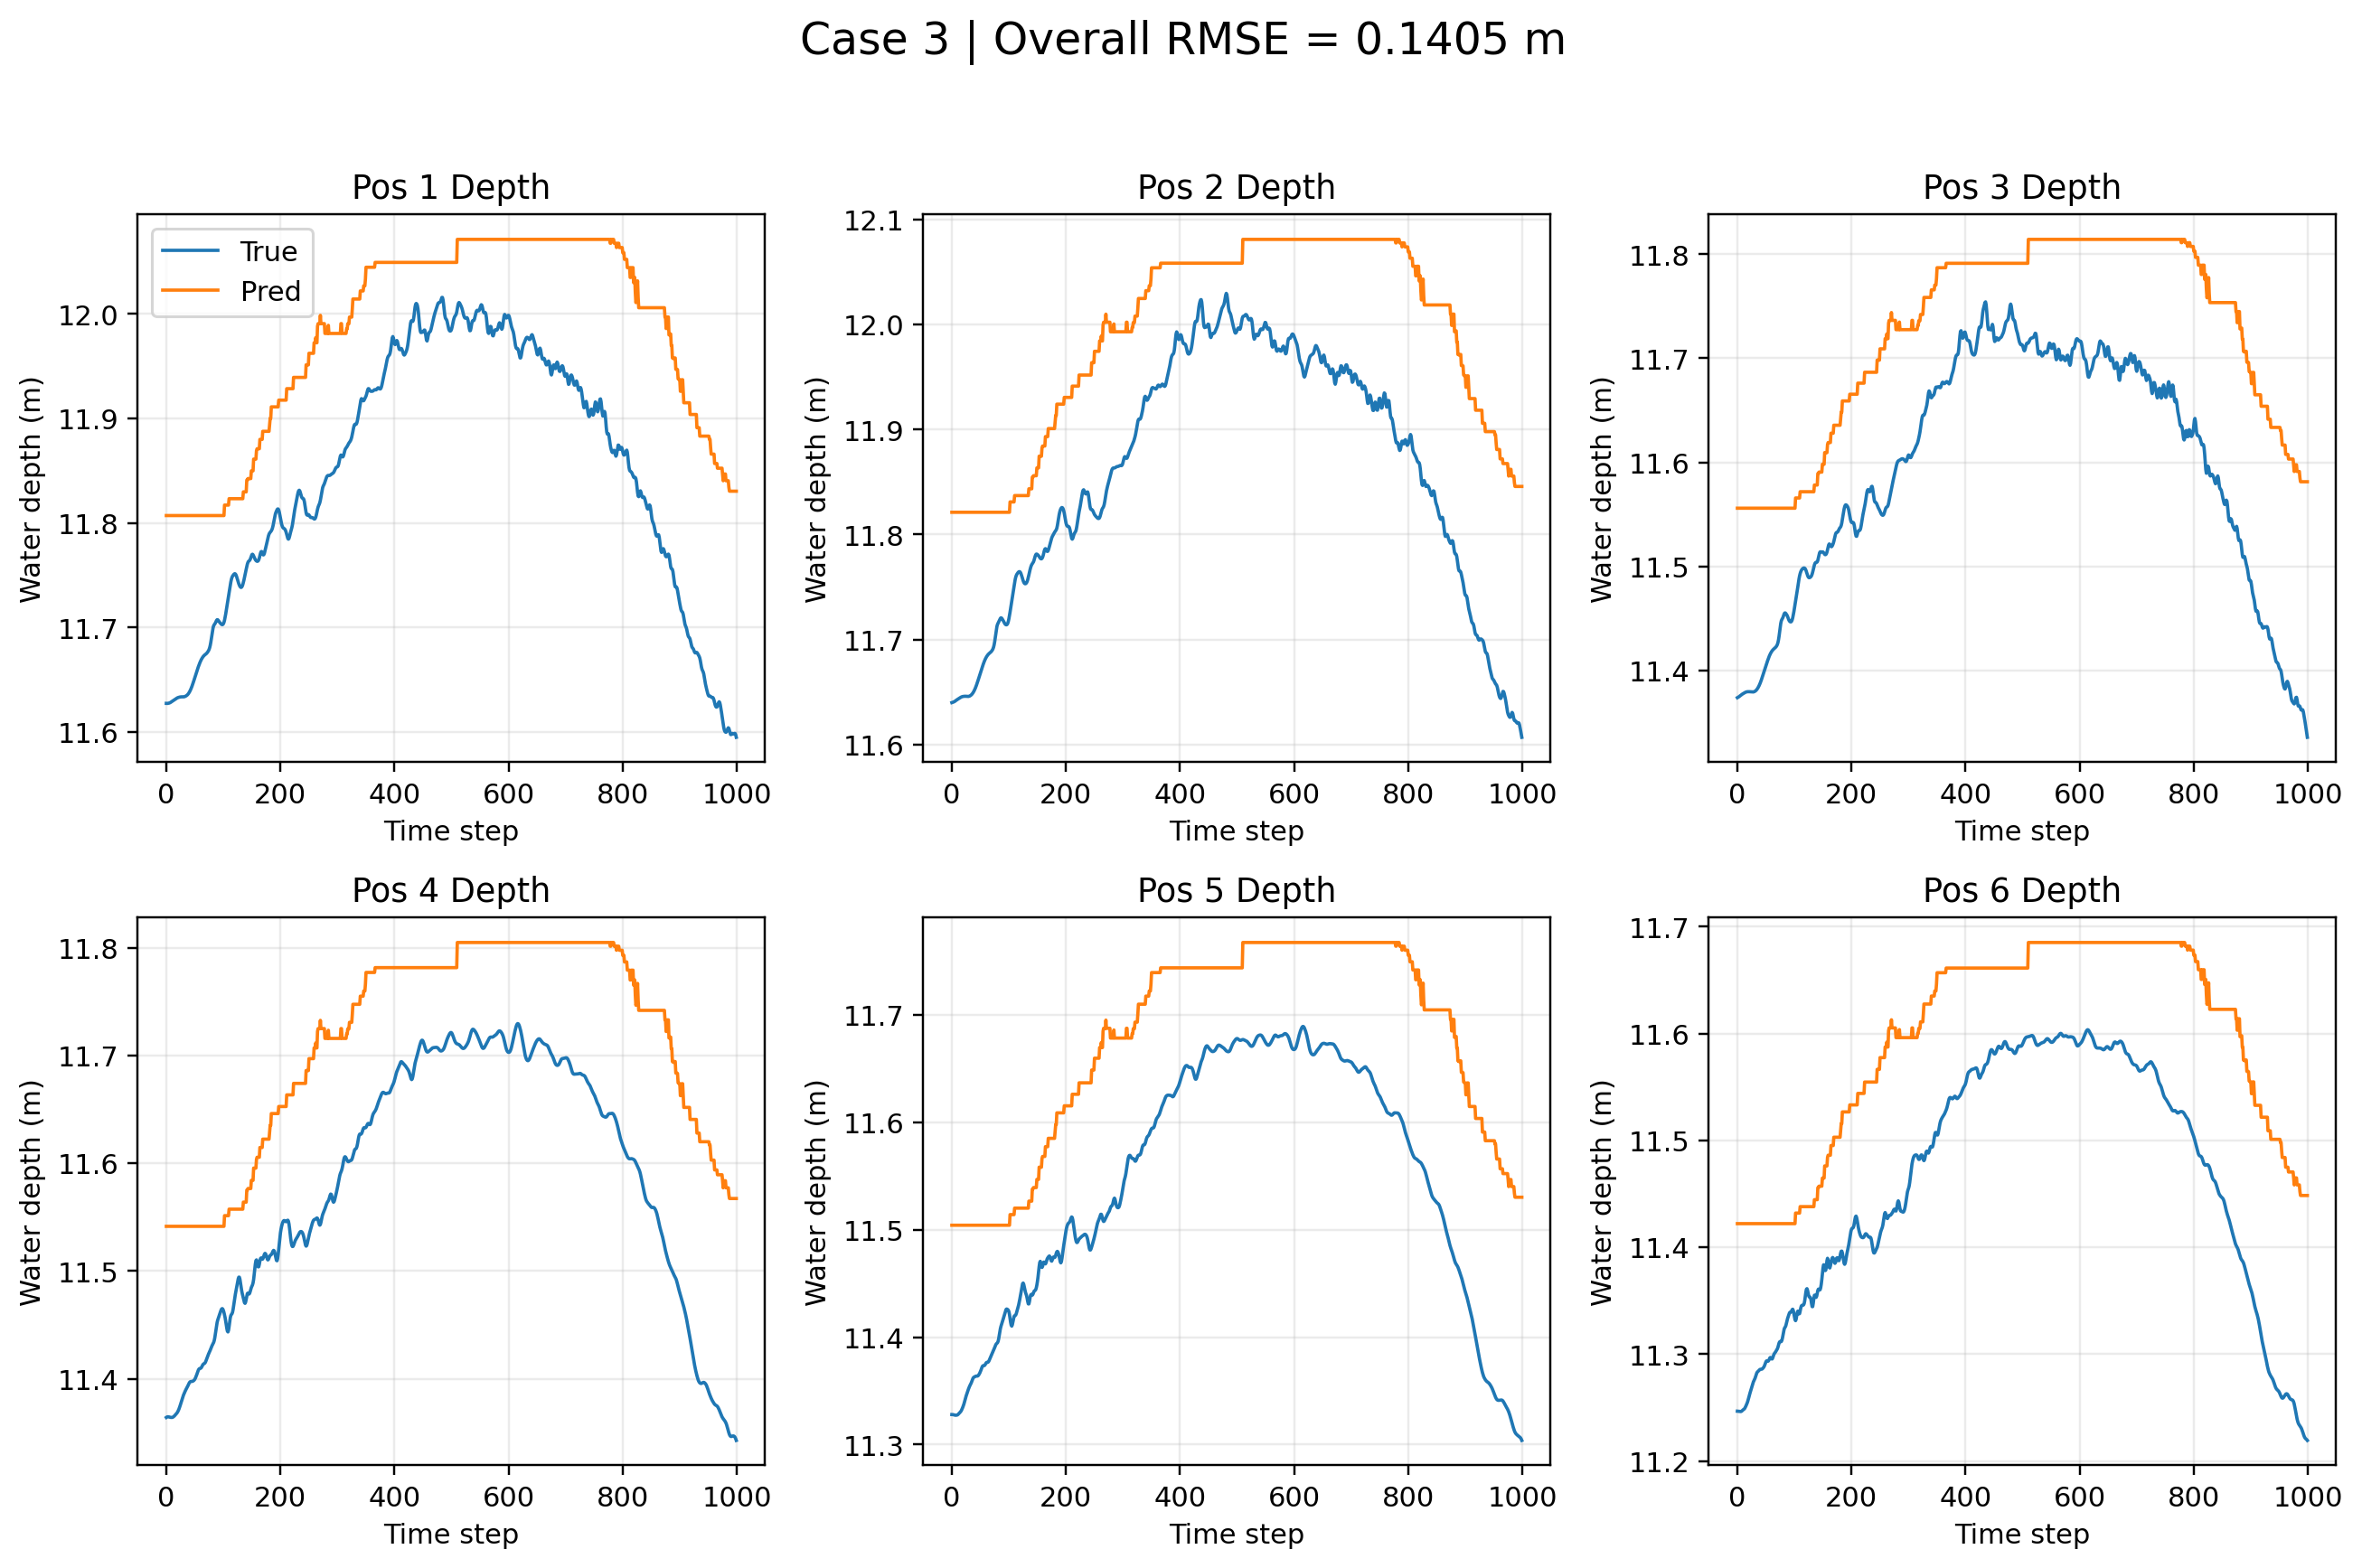

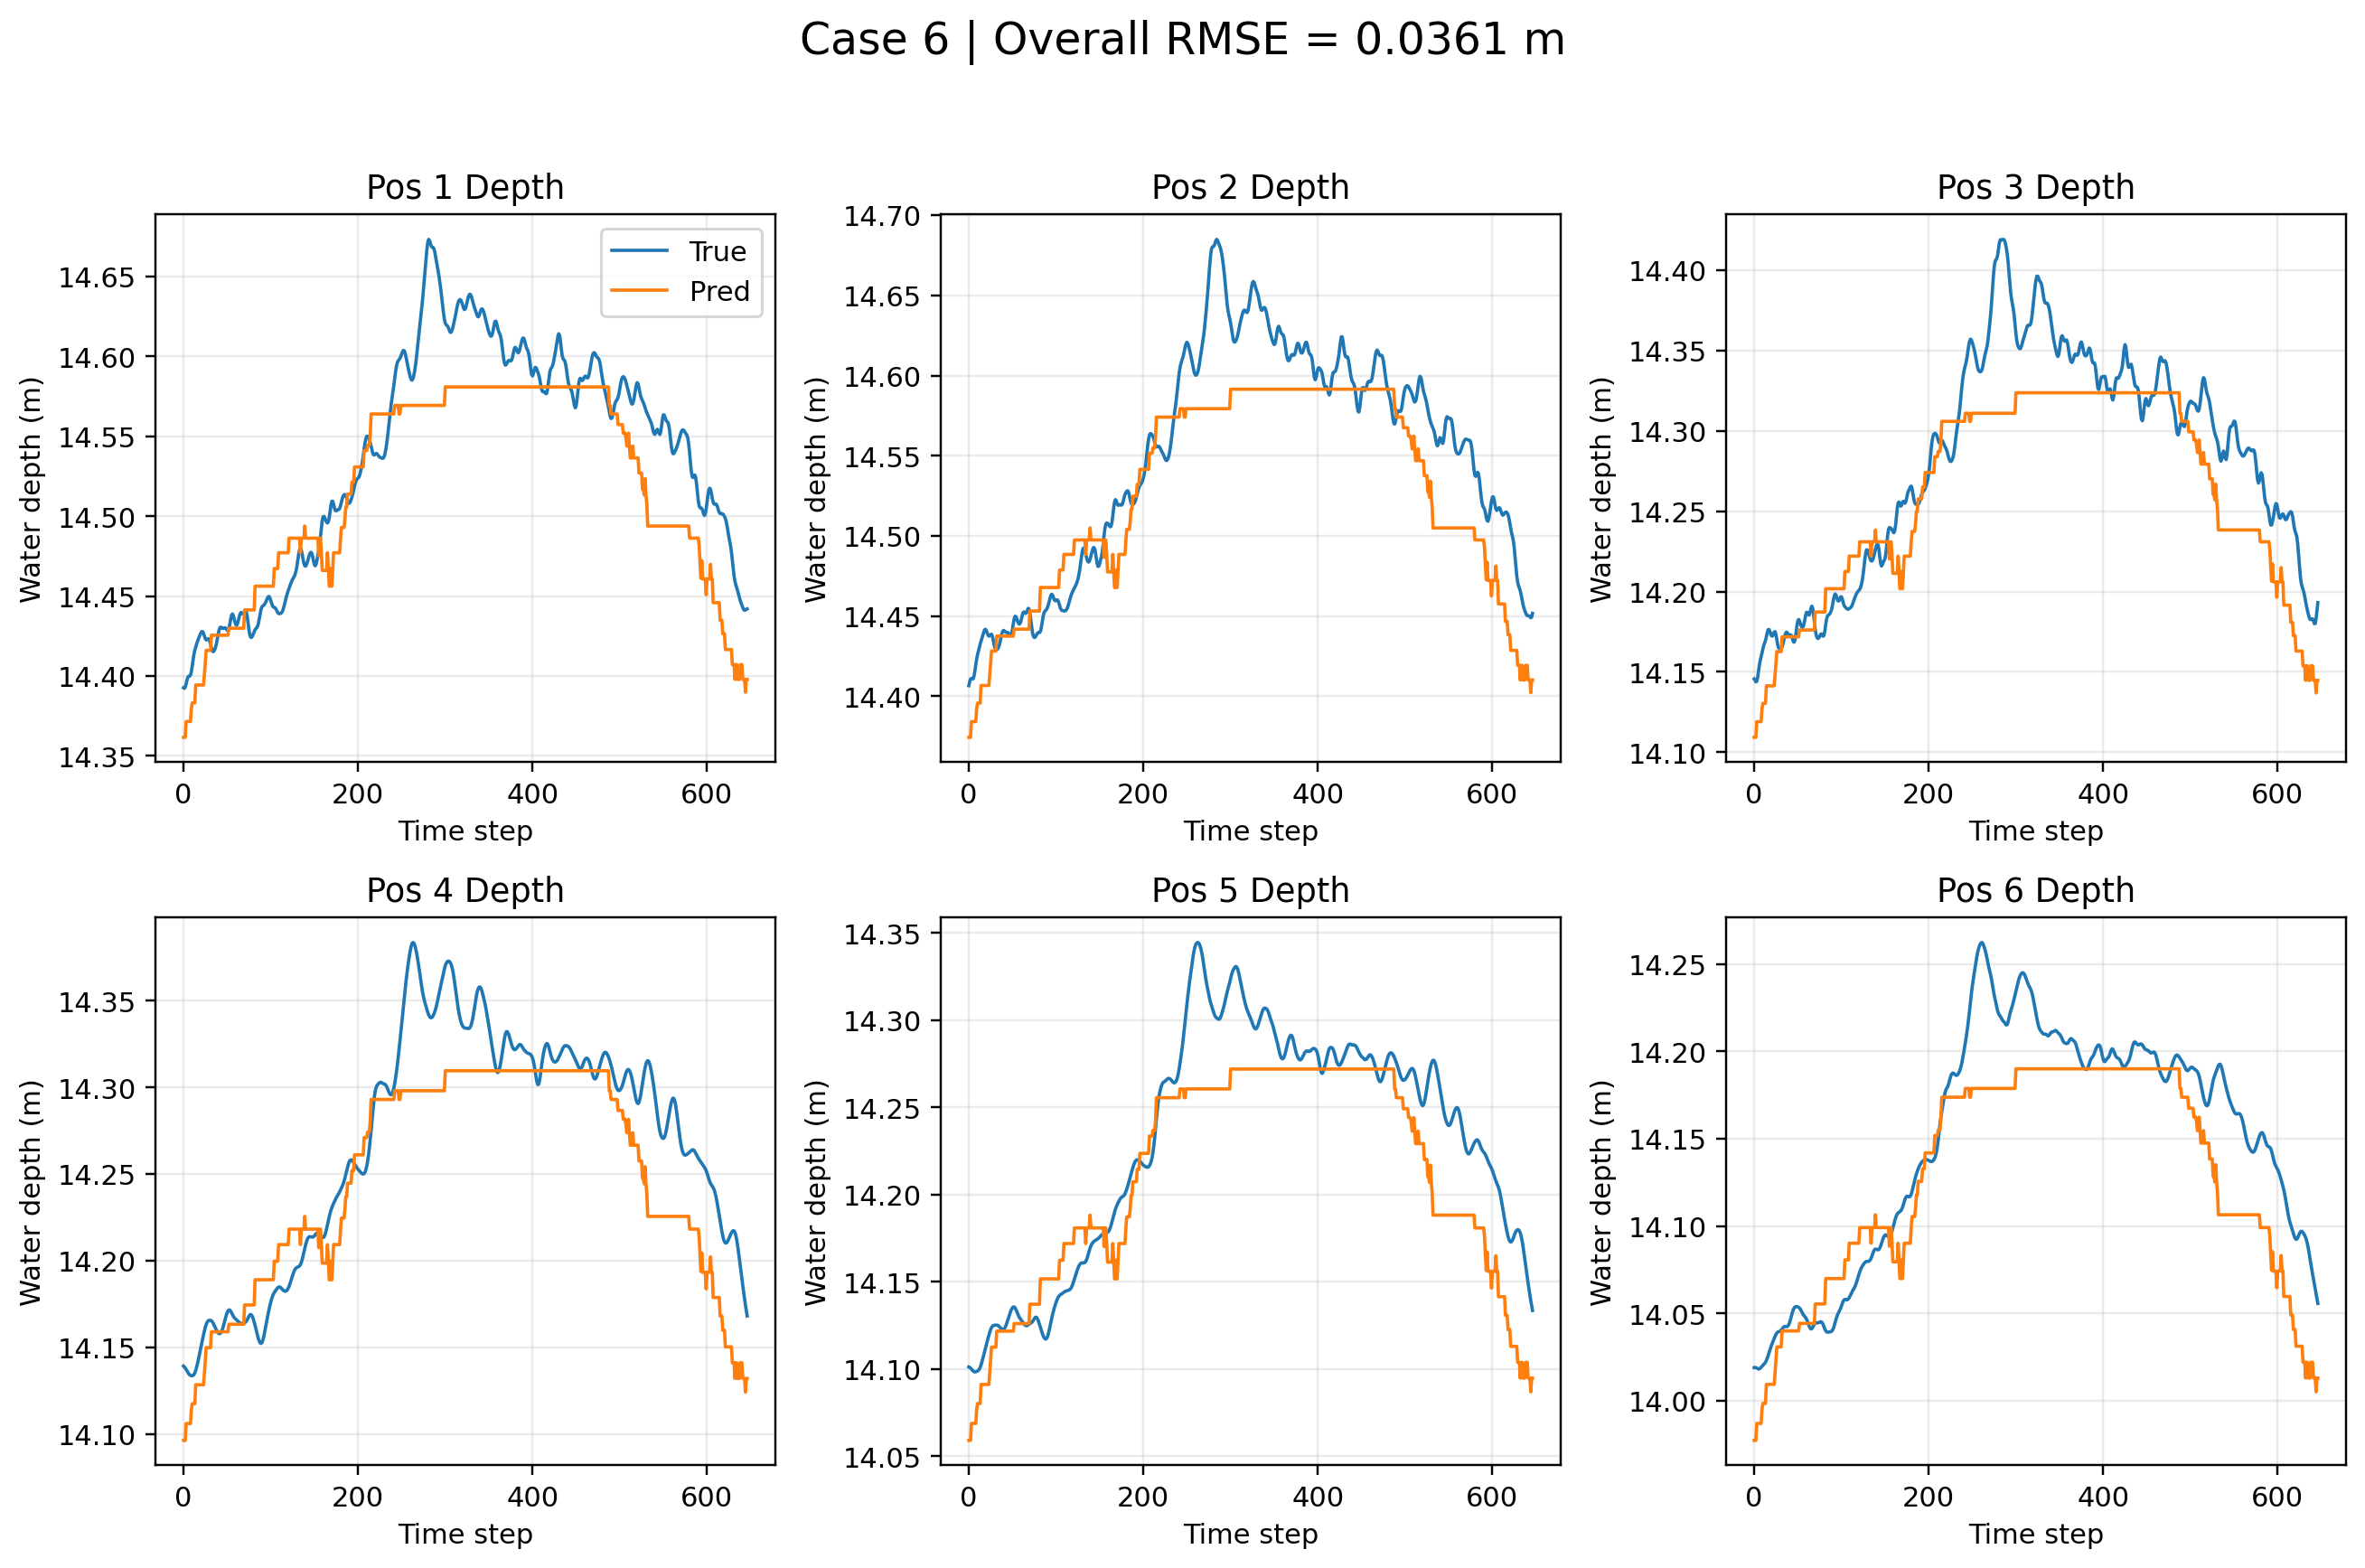

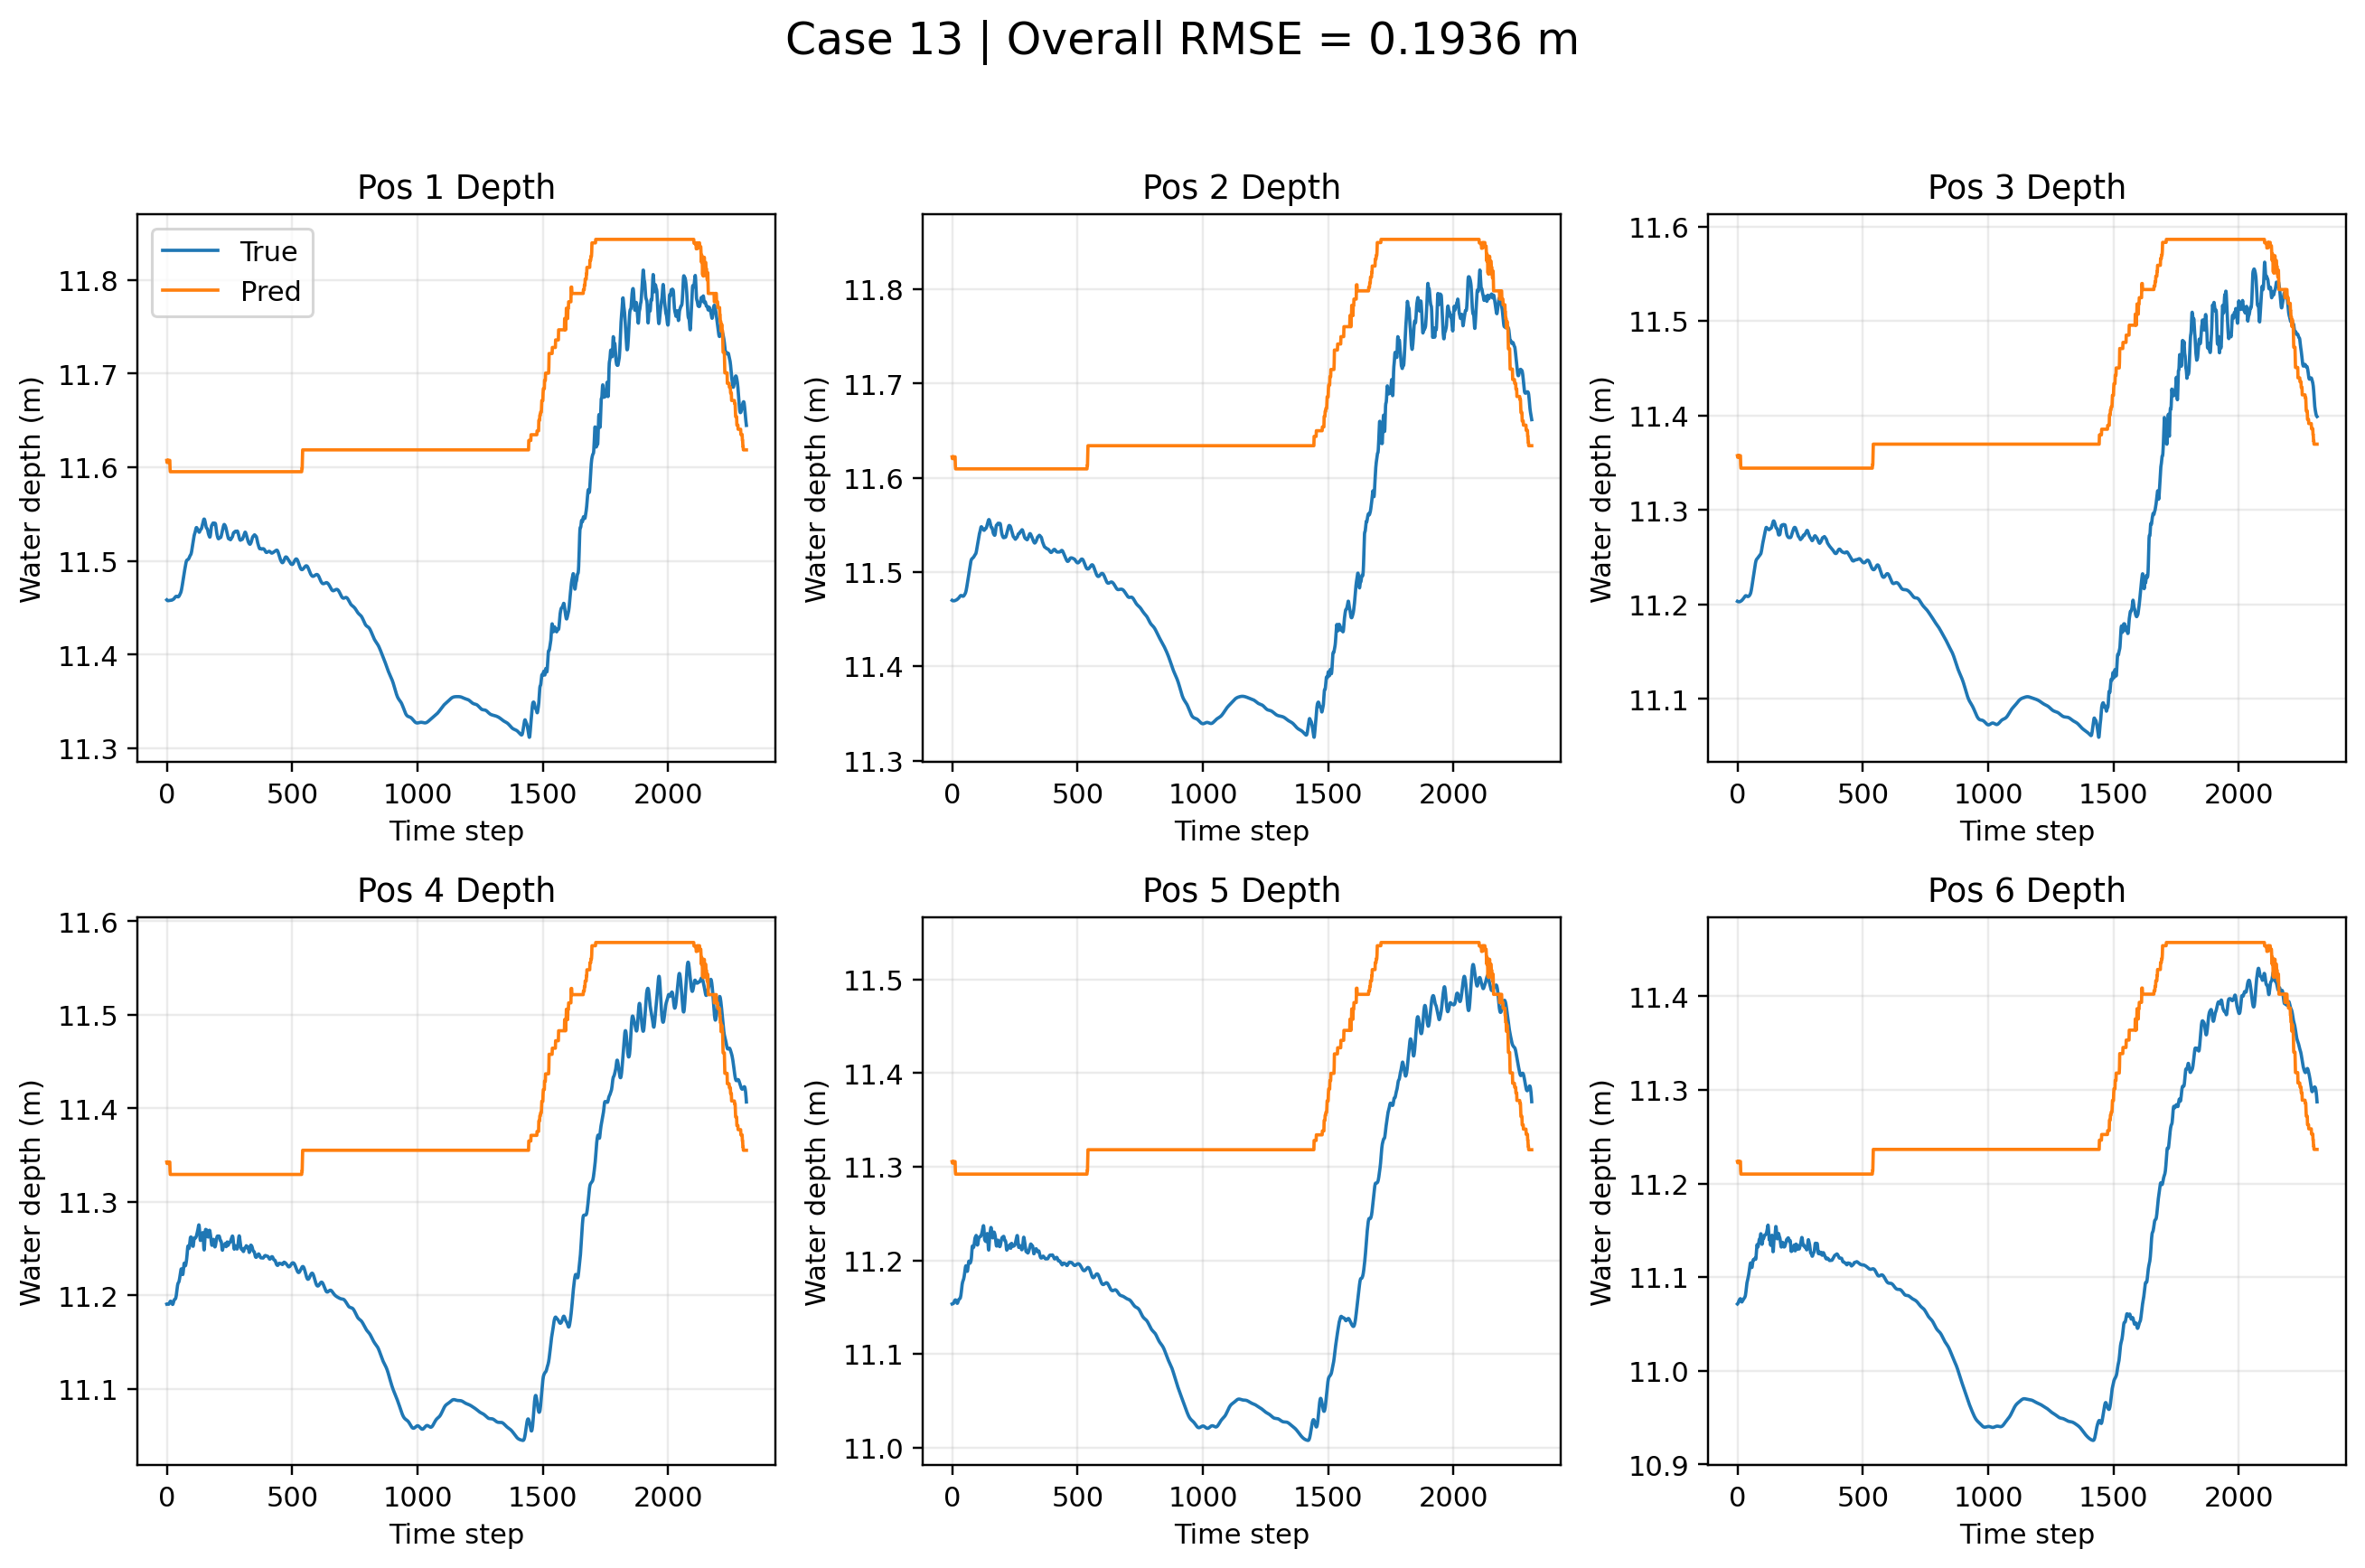

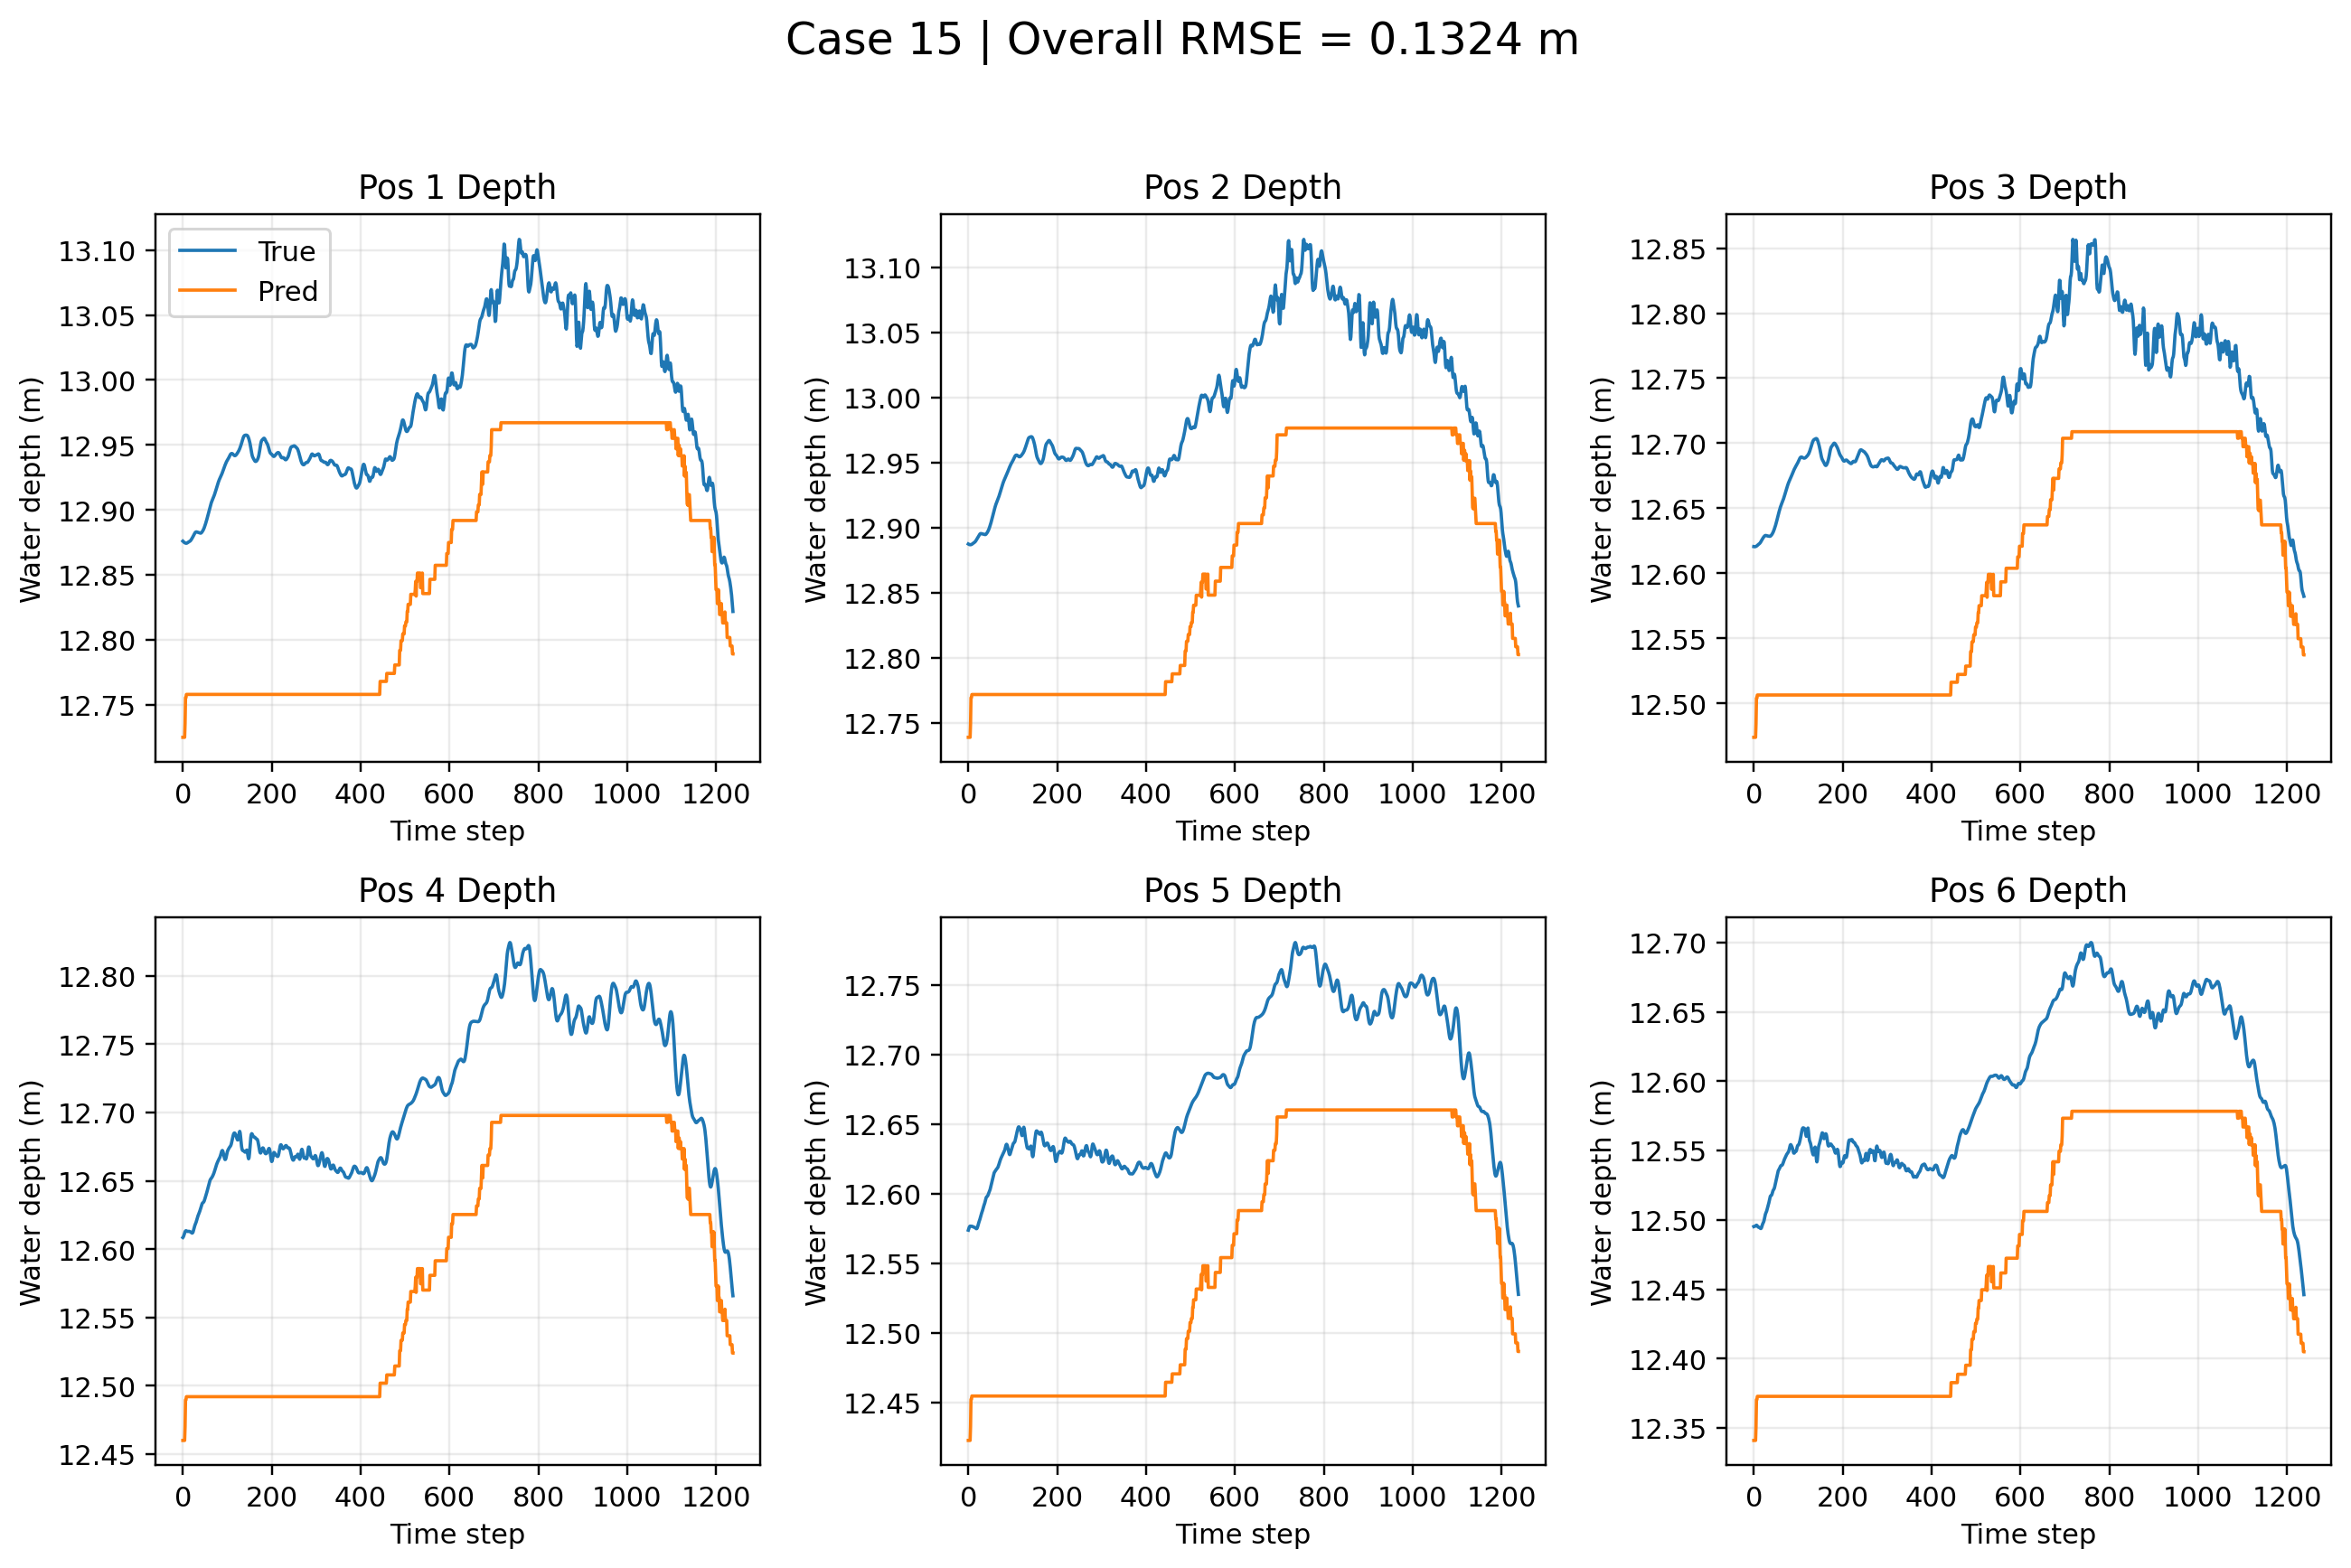

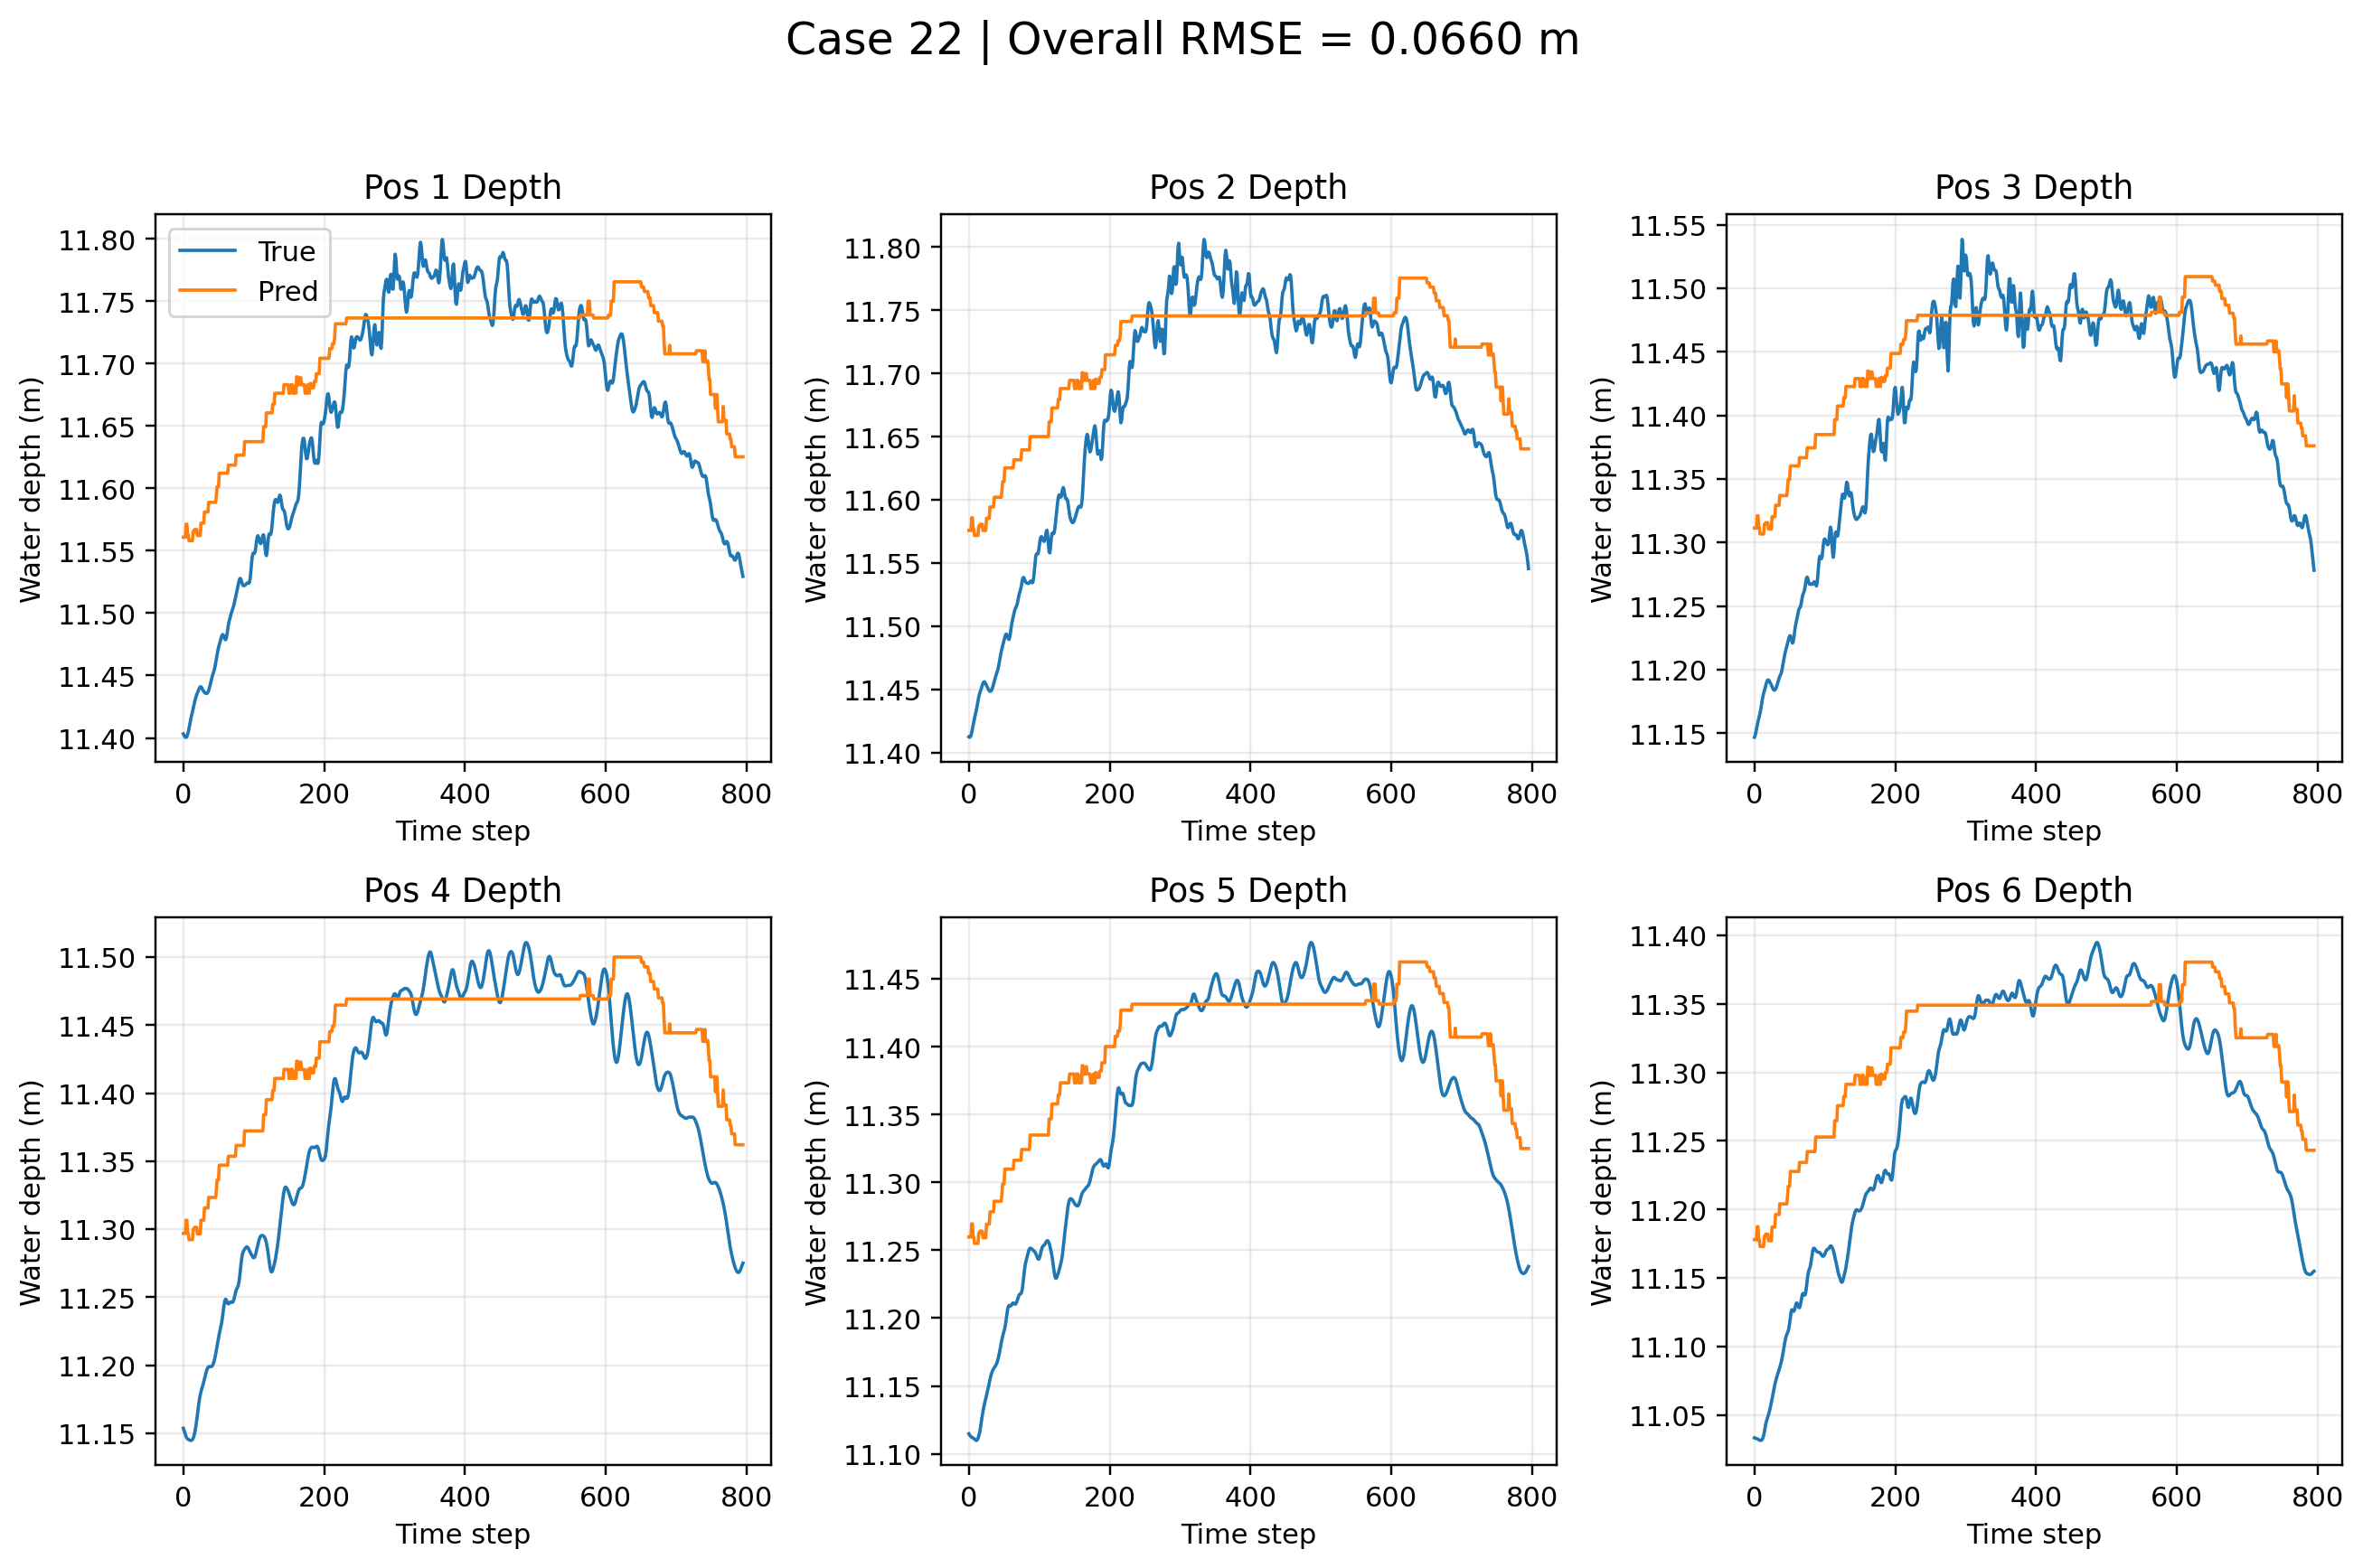

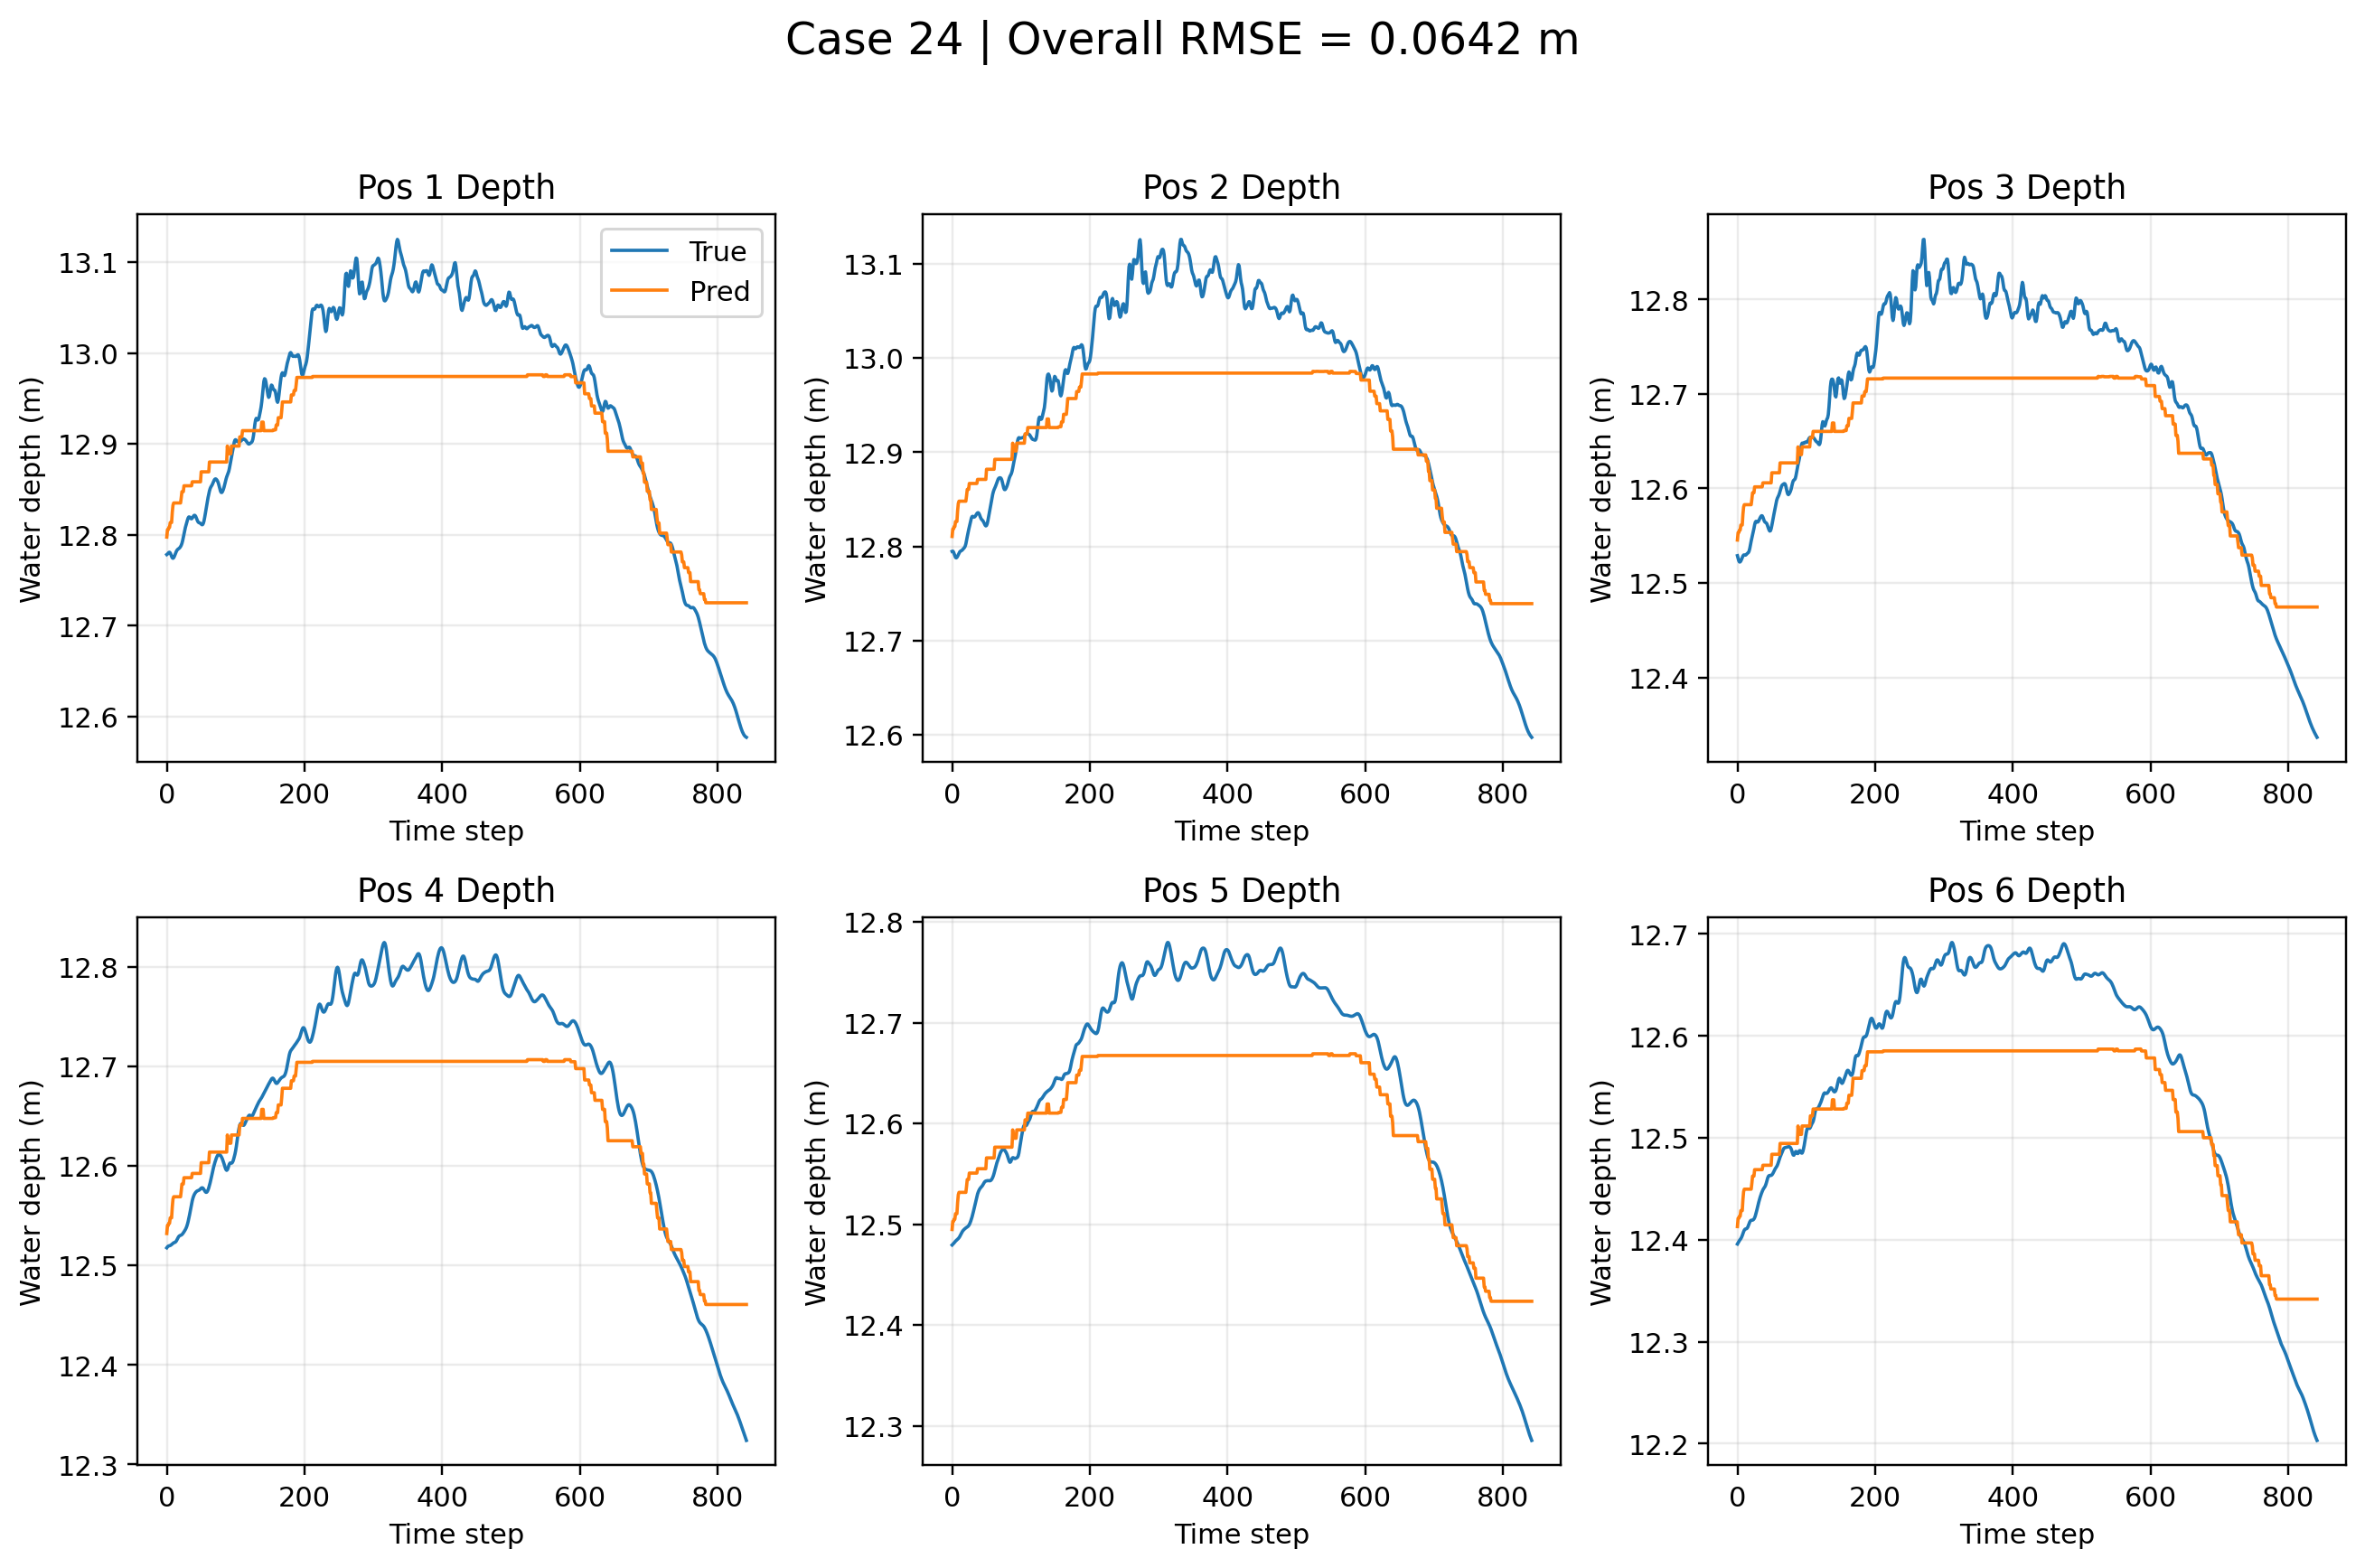

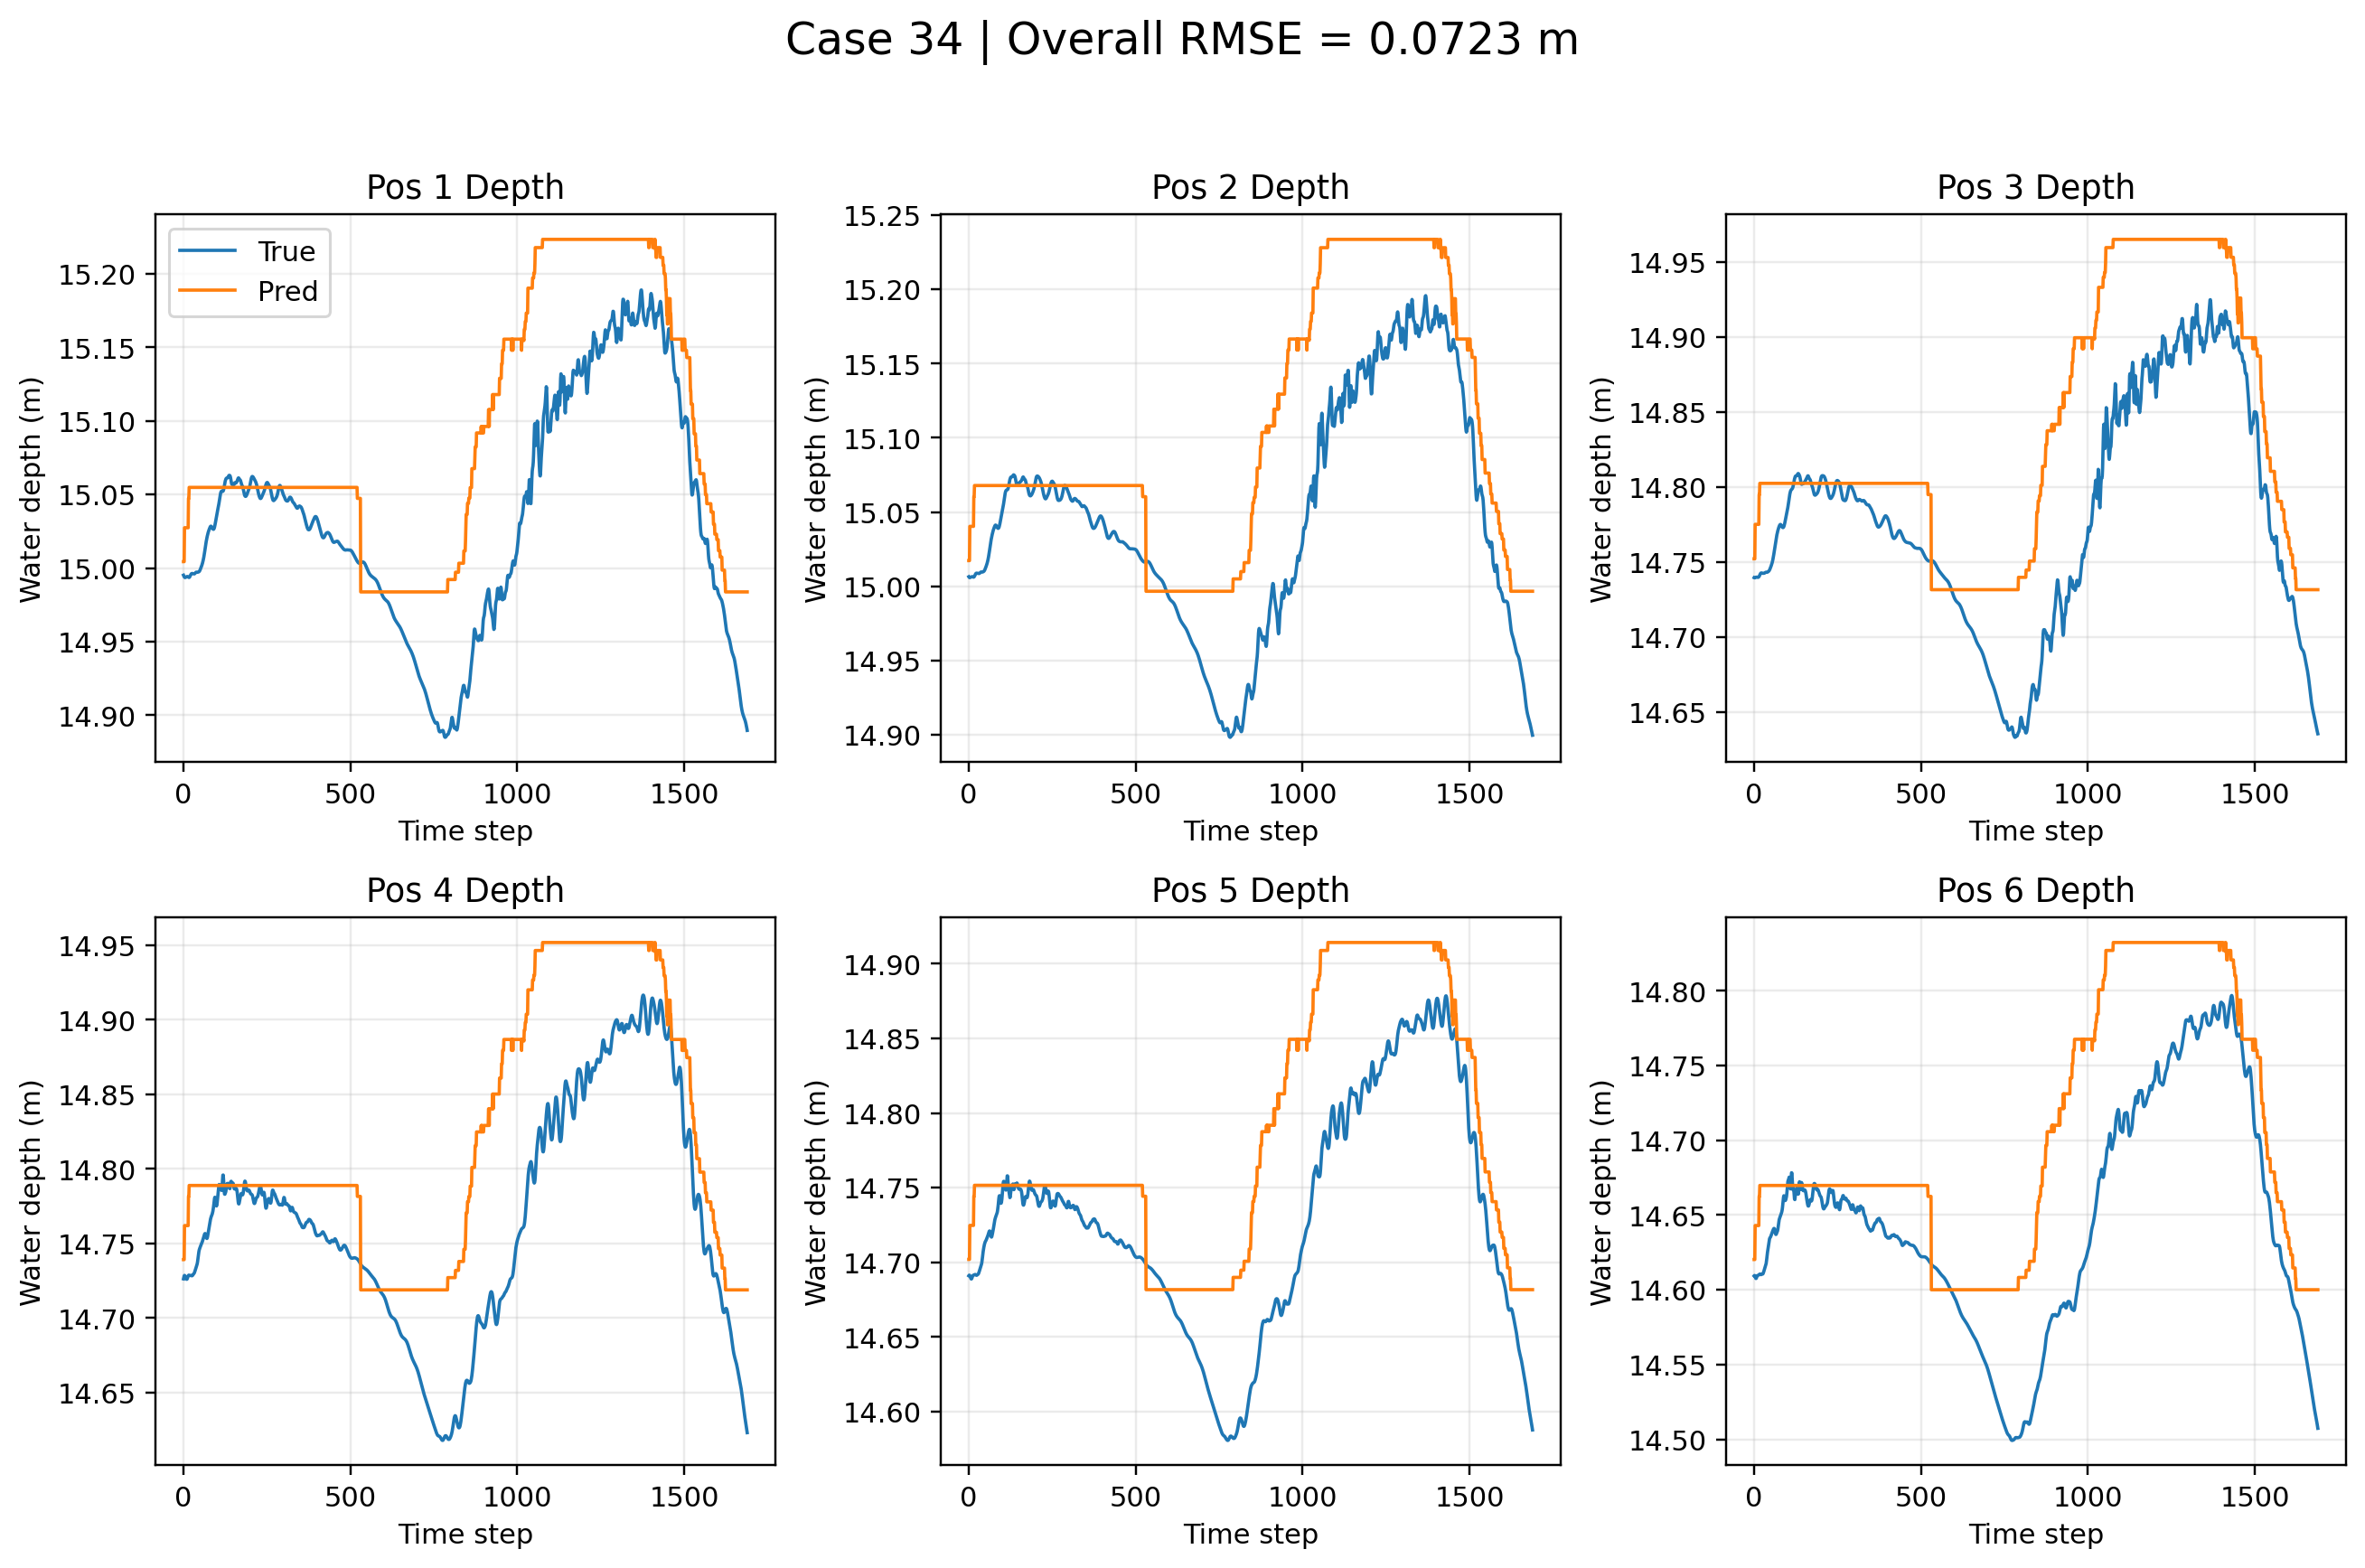

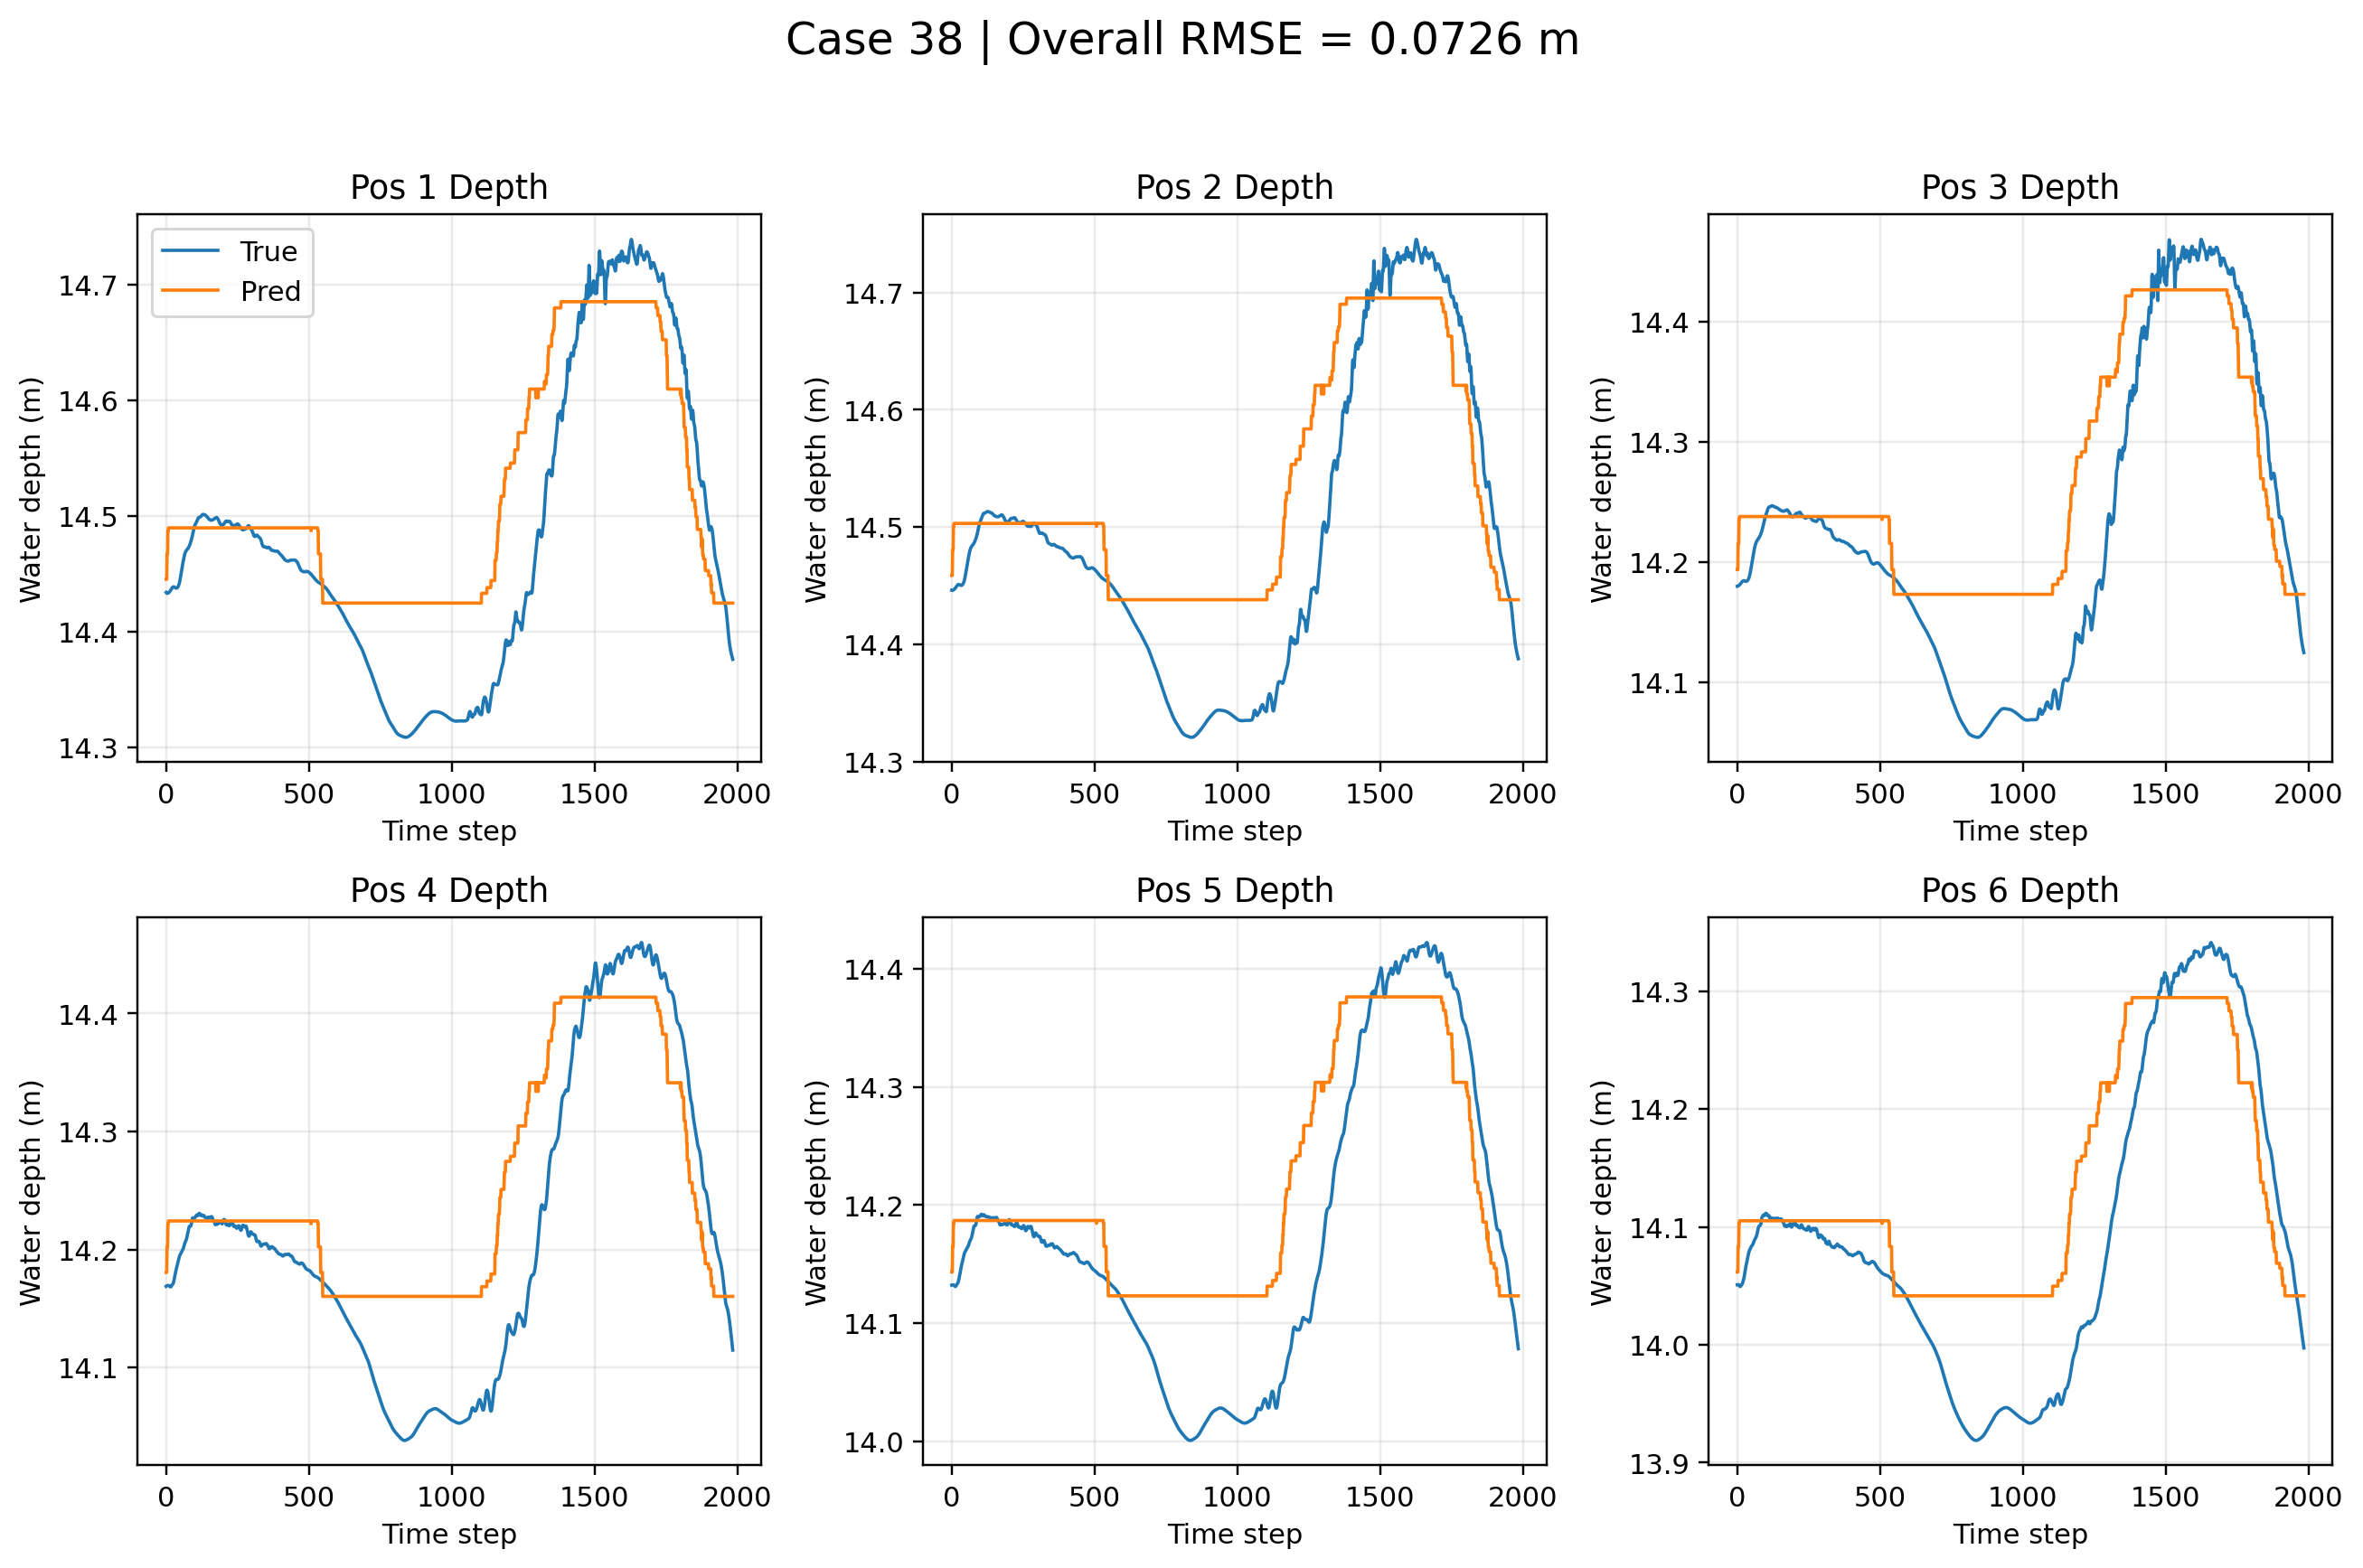

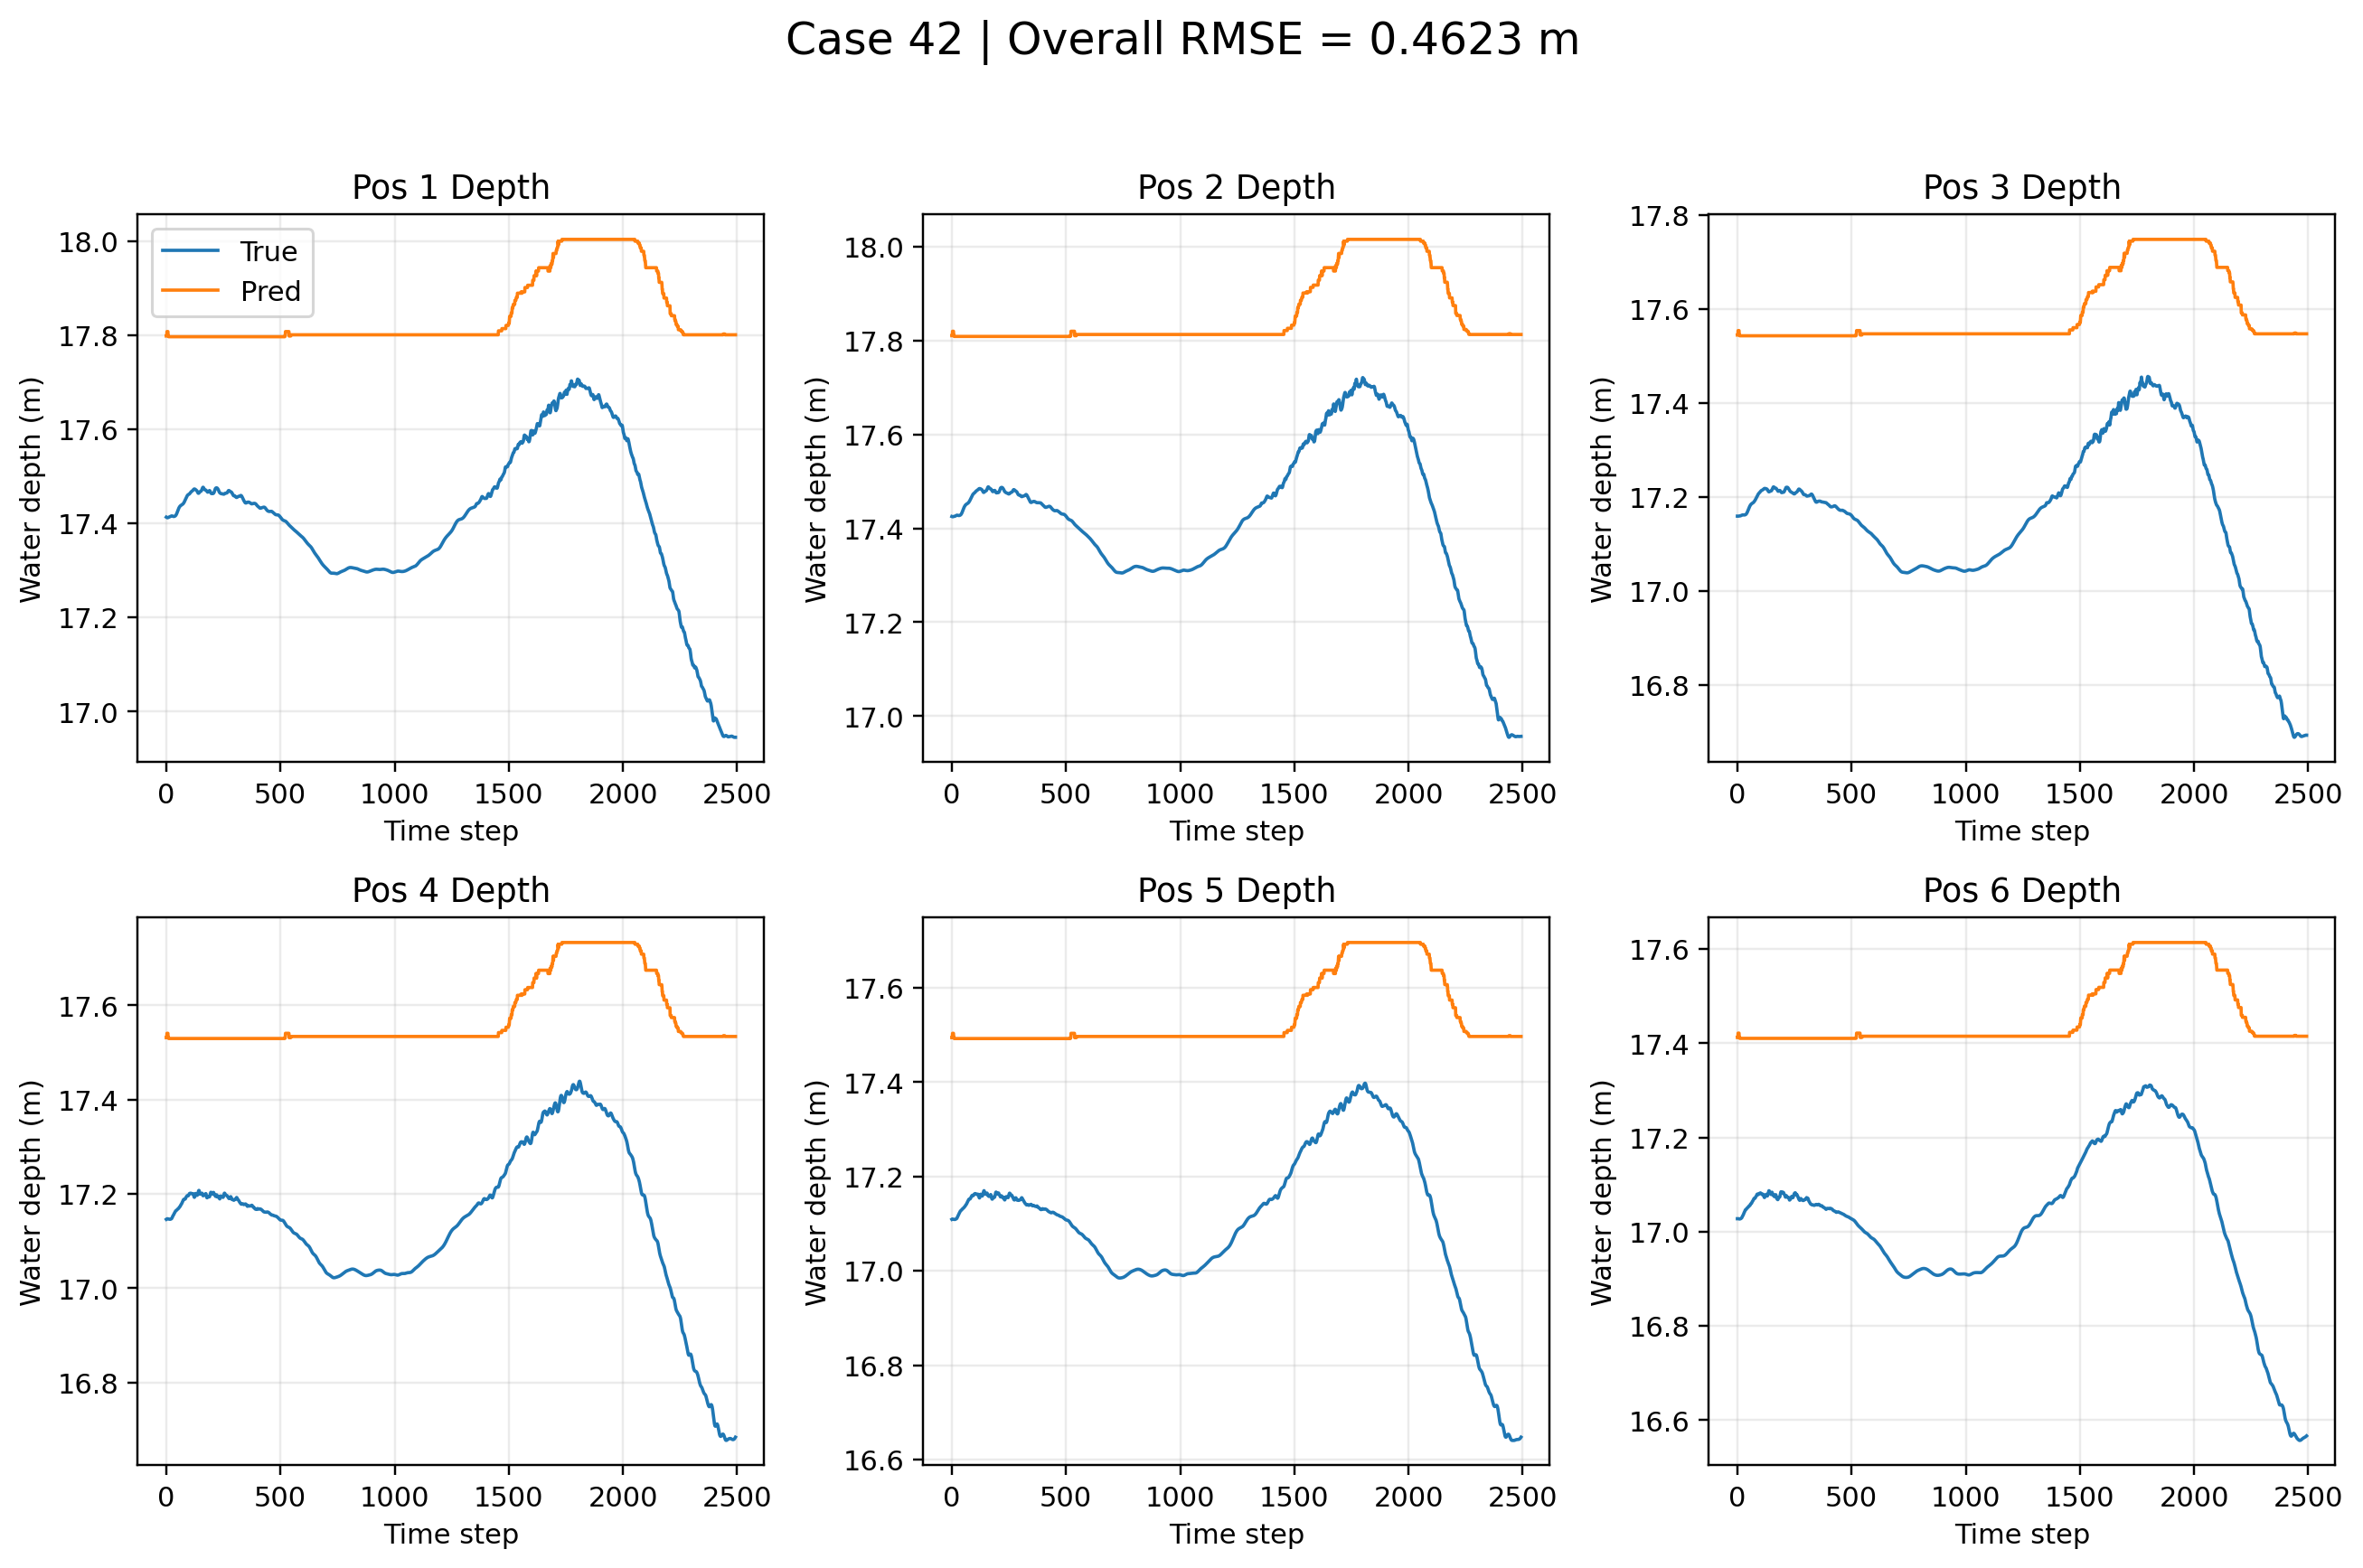

In [11]:
import matplotlib.pyplot as plt
import numpy as np

pos_names = [f"Pos {i}" for i in range(1, 7)]


for case_name, case_data in test_data_per_case.items():
    X_seq_case, X_static_case, Y_case = case_data

    X_seq_flat = X_seq_case.reshape(-1, X_seq_case.shape[-1])
    X_seq_case_norm = (X_seq_flat - X_seq_min) / (X_seq_max - X_seq_min + 1e-8)
    X_seq_case_norm = X_seq_case_norm.reshape(X_seq_case.shape)

    X_static_case_norm = (X_static_case - X_static_min) / (X_static_max - X_static_min + 1e-8)

    X_case_input = np.concatenate(
        [
            X_seq_case_norm,
            np.repeat(
                X_static_case_norm[:, np.newaxis, :],
                X_seq_case_norm.shape[1],
                axis=1
            )
        ],
        axis=-1
    )

    X_case_flat = X_case_input.reshape(X_case_input.shape[0], -1)

    y_pred_case = predict_cat(cat_model, X_case_flat)

    y_pred_case_real = y_pred_case * (Y_max - Y_min) + Y_min
    y_true_case_real = Y_case

    rmse_case = float(
        np.sqrt(np.mean((y_pred_case_real - y_true_case_real) ** 2))
    )

    t = np.arange(y_true_case_real.shape[0])

    fig, axes = plt.subplots(
        2, 3,
        figsize=(12, 8),
        dpi=220
    )
    axes = axes.ravel()

    fig.suptitle(
        f"Case {case_name} | Overall RMSE = {rmse_case:.4f} m",
        fontsize=16
    )

    for i in range(6):
        ax = axes[i]

        ax.plot(
            t,
            y_true_case_real[:, i],
            label="True",
            linewidth=1.2
        )
        ax.plot(
            t,
            y_pred_case_real[:, i],
            label="Pred",
            linewidth=1.2
        )

        ax.set_title(f"{pos_names[i]} Depth")
        ax.set_xlabel("Time step")
        ax.set_ylabel("Water depth (m)")
        ax.grid(True, alpha=0.25)

        if i == 0:
            ax.legend()

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
